# CloudSat collocations - Preprocessing

This notebook combines TIWP estimates from the various cloud datasets that were collocated with CloudSat estimates into single files.

In [1]:
from pathlib import Path
from typing import Dict

import cmocean
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
plt.style.use("../../ccic.mplstyle")

In [2]:
LAT_LIMITS = (-70, 69)

> **NOTE**:  The CloudSat-CCIC collocations only contain profiles within (-70, 69). Therefore, only those profiles are extracted here.

### Utility functions

The functions below extract dates from collocation files to simplify checking the temporal coverage of the extracted collocations.

In [3]:
from datetime import datetime
from typing import Union
from pansat.time import to_datetime64
from typing import List


def get_date(fname: Union[Path, str]) -> np.datetime64:
    """
    Extract date from collocation file.

    Args:
        fname: Filename of path pointing to a collocation file.

    Return:
         A np.datetime64 object representing the time of the collocation.
    """
    if isinstance(fname, str):
        fname = Path(fname)

    date = datetime.strptime(fname.name.split('_')[-2], "%Y%m%d%H%M%S")
    return to_datetime64(date)

In [4]:
def plot_collocation_availability(files: List[Path]) -> None:
    """
    Plot number of available collocations by month.

    Args:
         files: A list containing the collocation files.
    """
    dates = np.array(list(map(get_date, files)))
    start_time = dates.min()
    end_time = dates.max()
    print(start_time, end_time)
    bins = np.arange(start_time, end_time + np.timedelta64(1, "h"), np.timedelta64(1, "D"))
    print(bins)
    y = np.histogram(dates, bins)[0]
    x = bins[:-1] + 0.5 * (bins[1:] - bins[:-1])
    plt.plot(x, y)

## ISCCP

The following steps are used here to extract TIWP estimates from ISCCP files:

1. Load cloud type amount (``cldamt_types``) and mask values outside the valid range $[-500, 500]$ as defined in the variable description
2. Load cloud water path by type (``wp_type``) and mask values outside the valid range $[-500, 500]$ as defined in the variable description
3. Load ``scene`` variable and mask night-time pixels, which have mask values $\geq 100$

The third step is necessary because ``wp_type`` is available only during day and for cloudy pixels thus making it impossible to distinguish non-cloudy and night-time pixels. ``cldamt_types``, however, is calculated for both day-time and night-time pixels thus not providing any way to discriminate day-time and night-time pixels.

In [5]:
isccp_data = xr.load_dataset("/scratch/ccic_record/data/isccp/ISCCP-Basic.HGG.v01r00.GLOBAL.2006.06.02.1500.GPC.10KM.CS00.EA1.00.nc")
cloud_types = isccp_data.cloud_type_label
frozen_cloud_mask = np.array(
    ["_ice" in cloud_type.decode() for cloud_type in cloud_types.data]
)

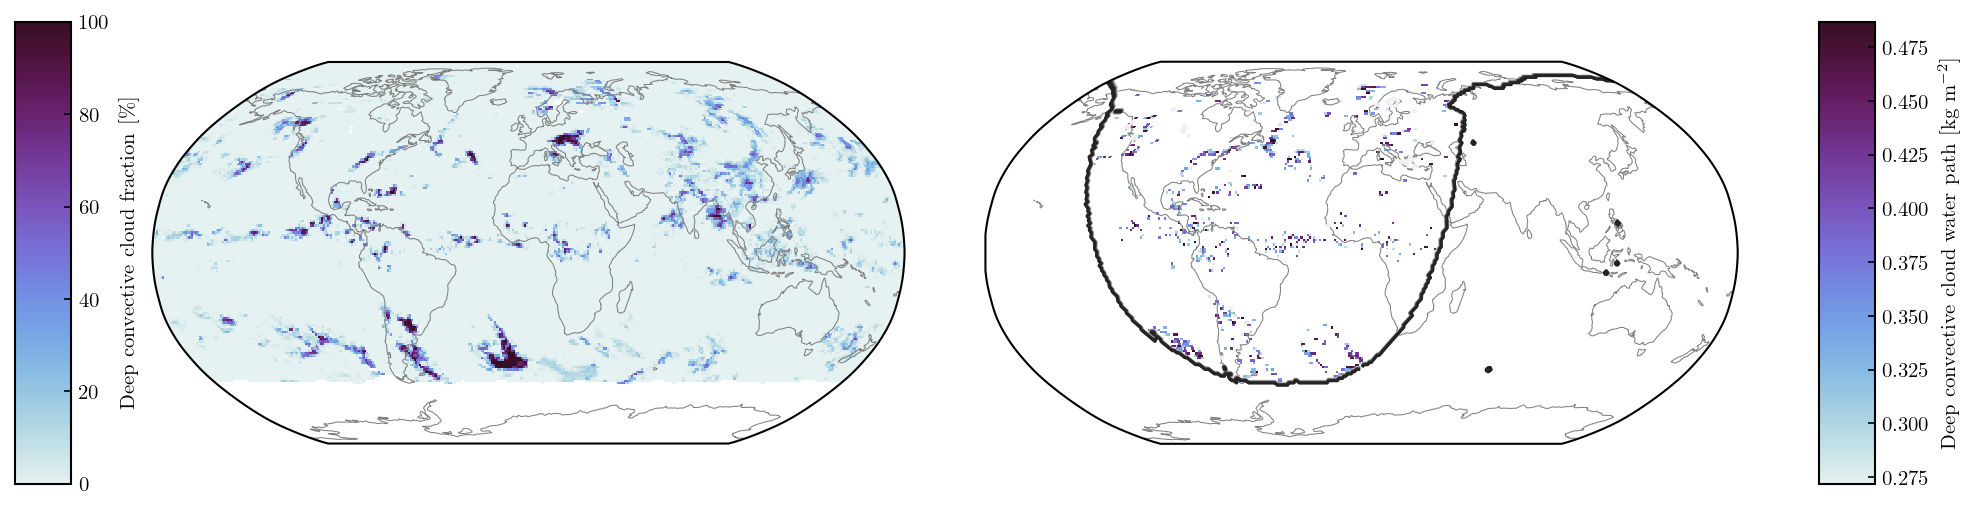

In [6]:
import cartopy.crs as ccrs
from matplotlib.gridspec import GridSpec

crs = ccrs.Robinson()

fig = plt.figure(figsize=(16, 4))
gs = GridSpec(1, 4, width_ratios=[0.075, 1.0, 1.0, 0.075])

# CLDAMT
ax = fig.add_subplot(gs[0, 1], projection=crs)
cldamt_dc = isccp_data.cldamt_types[0, -1].data.copy()
invalid = (cldamt_dc < -500) + (cldamt_dc > 500)
cldamt_dc[invalid] = np.nan
lats = isccp_data.lat.data
lons = isccp_data.lon.data
m = ax.pcolormesh(lons, lats, cldamt_dc, transform=ccrs.PlateCarree())
ax.coastlines(color="grey")

cax = fig.add_subplot(gs[0, 0])
plt.colorbar(m, cax=cax, label="Deep convective cloud fraction [$\si{\percent}$]")

# WP
ax = fig.add_subplot(gs[0, 2], projection=crs)
wp_dc = isccp_data.wp_type[0, -1].data.copy()
invalid = (wp_dc < -500) + (wp_dc > 500)
wp_dc[invalid] = np.nan
lats = isccp_data.lat.data
lons = isccp_data.lon.data
scene = isccp_data.scene.data[0]
m = ax.pcolormesh(lons, lats, wp_dc / 1e3, transform=ccrs.PlateCarree())
ax.contour(lons, lats, scene, cmap="Greys", transform=ccrs.PlateCarree())
ax.coastlines(color="grey")

cax = fig.add_subplot(gs[0, 3])
plt.colorbar(m, cax=cax, label="Deep convective cloud water path [kg m$^{-2}$]")

In [7]:
from typing import Optional

def calculate_wp(isccp_data, cloud_types: Optional[np.ndarray] = None) -> np.ndarray:
    """
    Calculates the water path by summing of the cloud-type-specific water paths.

    The water paths are calculated as follows:
        1. Identification of invalid pixels: Any pixel with cldamt_type outside the valid range [-500, 500] is masked.
        2. Identifiaction of day-time pixels: Any pixel with 'scene' > 100 is set to NAN to mask night-time retrievals since
            cloud-type information is avilable only during day time.
        3. Cloud-type water paths are scaled by their relative contribution to total cloud amount and summed.
    """
    if "wp_type" in isccp_data:
        wp_type = isccp_data.wp_type.data.copy()
    else:
        wp_type = isccp_data.wp_types.data.copy()
    cldamt_type = isccp_data.cldamt_types.data.copy()
    tot_cldamt = cldamt_type.sum(-1, keepdims=True).copy()
    
    if cloud_types is not None:
        wp_type = wp_type[..., cloud_types]
        cldamt_type = cldamt_type[..., cloud_types]
    invalid = (
        (cldamt_type < -500) + (cldamt_type > 500)
    )
    wp_type[invalid] = np.nan
    cldamt_type[invalid] = np.nan
    night_mask = isccp_data.scene.data >= 100
    wp_type[night_mask] = np.nan
    cldamt_type[night_mask] = np.nan
    wp = (wp_type * cldamt_type / tot_cldamt).sum(-1)

    zero_wp = np.isclose(tot_cldamt[..., 0], 0.0) * ~night_mask
    wp[zero_wp] = 0.0
    
    return wp / 1e3

In [8]:
def get_tiwp_isccp(dataset: xr.Dataset) -> xr.DataArray:
    """
    Extract ISCCP TIWP from collocation file.

    Args:
        dataset: A xarray.Dataset containing ISCCP-CloudSat collocations.

    Return:
        A DataArray containing the extracted TIWP
    """
    if "modis_pixels" in dataset:
        dataset = dataset[{"modis_pixels": 7}]
    lat_mask = (LAT_LIMITS[0] < dataset.latitude) * (dataset.latitude < LAT_LIMITS[1])
    dataset = dataset[{"rays": lat_mask}]
    day_flag = dataset.scene.data < 100

    tiwp = calculate_wp(dataset, frozen_cloud_mask)
    return xr.DataArray(
        tiwp,
        dims=("rays",),
        coords = {
            "time": (("rays",), dataset.time.data),
            "latitude": (("rays",), dataset.latitude.data),
            "longitude": (("rays"), dataset.longitude.data),
        }
    )

In [9]:
isccp_granule = xr.load_dataset("/scratch/ccic_record/collocations/isccp/isccp_20130101005408_35533.nc")

/tmp/ipykernel_2955872/4002563853.py:31: RuntimeWarning: invalid value encountered in divide
  wp = (wp_type * cldamt_type / tot_cldamt).sum(-1)


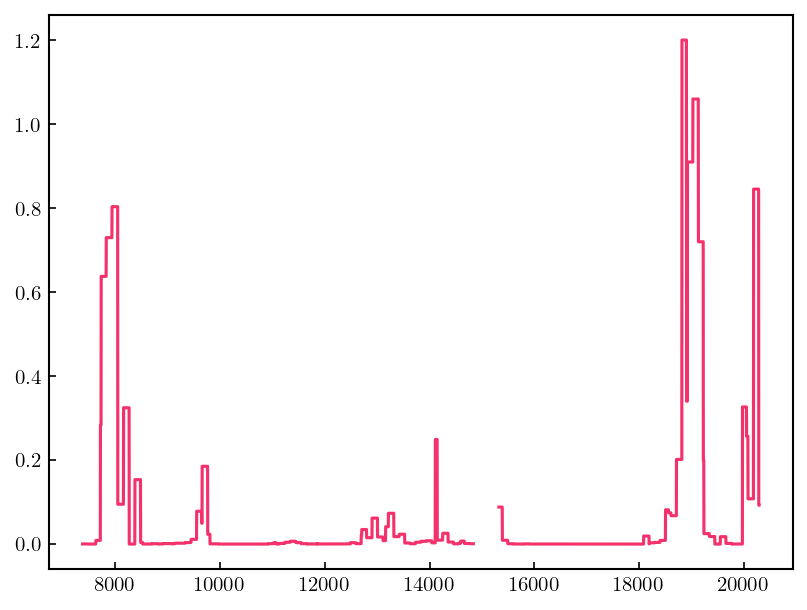

In [10]:
plt.plot(get_tiwp_isccp(isccp_granule))

### Temporal coverage

In [11]:
files = sorted(list(Path("/scratch/ccic_record/collocations/isccp").glob("*.nc")))

2006-06-02T13:42:29.000000000 2017-06-04T03:28:46.000000000
['2006-06-02T13:42:29.000000000' '2006-06-03T13:42:29.000000000'
 '2006-06-04T13:42:29.000000000' ... '2017-06-01T13:42:29.000000000'
 '2017-06-02T13:42:29.000000000' '2017-06-03T13:42:29.000000000']


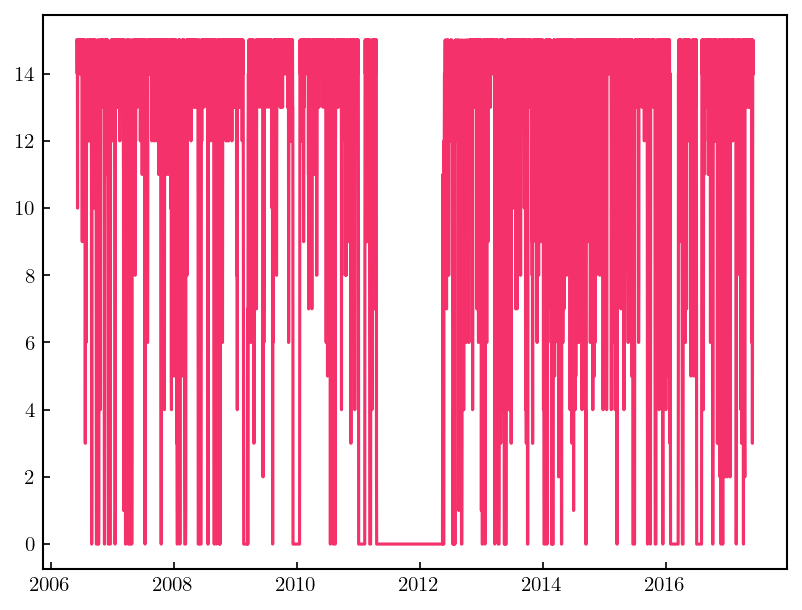

In [12]:
plot_collocation_availability(files)

## PATMOS-x

The problem is similar for PATMOS-x data in that WP values are only available for cloudy day-time pixels requiring them to be combined with a day-time flag to distinguish pixels without IWP from those where no retrieval was performed. For PATMOS-x the following steps are performed:

1. Determine pixels with valid retrieval results using pixels where the DCOMP-determined optical depth is finite (``np.isfinite(patmosx_data.cld_opd_dcomp)``)
2. Determine IWP for cloudy pixels by extracting the water path (``cld_cwp_dcomp.``) for ice clouds ``cloud_phase == 4``.

In [13]:
patmosx_data = xr.load_dataset("/scratch/ccic_record/data/PATMOS-x/raw_custom/patmosx_v06r00_NOAA-19_des_d20210515_c20231219_v2.zarr")

/scratch/spfrnd/micromamba/envs/ccic_record/lib/python3.10/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/scratch/spfrnd/micromamba/envs/ccic_record/lib/python3.10/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'h5netcdf' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/scratch/spfrnd/micromamba/envs/ccic_record/lib/python3.10/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


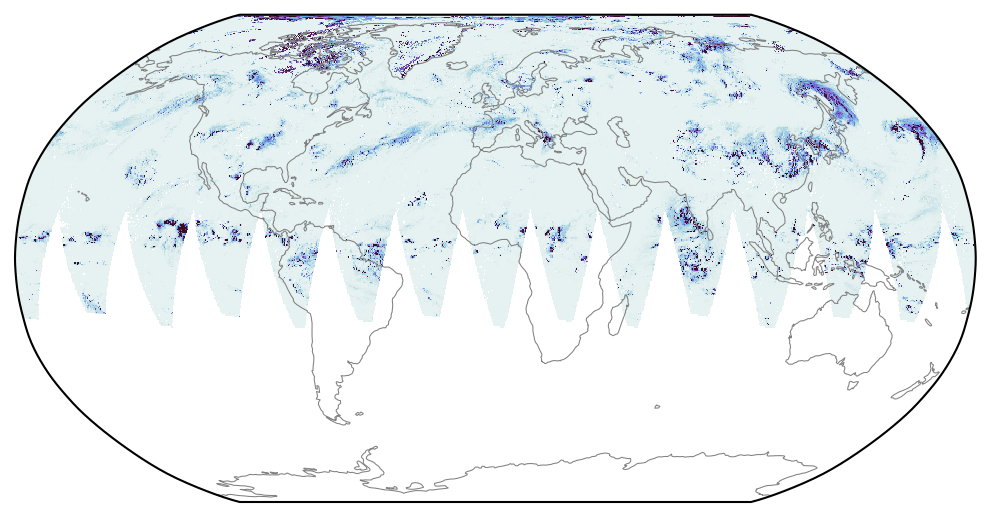

In [14]:
import cartopy.crs as ccrs
from matplotlib.gridspec import GridSpec

crs = ccrs.Robinson()

fig = plt.figure(figsize=(10, 5))
gs = GridSpec(1, 2, width_ratios=[1.0, 0.1])

# Cloud water path
ax = fig.add_subplot(gs[0, 0], projection=crs)
lons = patmosx_data.longitude.data
lats = patmosx_data.latitude.data
ax.pcolormesh(lons[::4], lats[::4], patmosx_data.cld_iwp_dcomp.data[0, ::4, ::4], transform=ccrs.PlateCarree())
#ax.contour(lons, lats, np.isfinite(patmosx_data.cld_opd_dcomp.data[0, ::4, ::4]), transform=ccrs.PlateCarree(), cmap="Greys")
ax.coastlines(color="grey")

In [15]:
def get_tiwp_patmosx(dataset: xr.Dataset) -> xr.DataArray:
    """
    Extract PATMOS-x TIWP from collocation file.

    Args:
        dataset: A xarray.Dataset containing PATMOS-x/CloudSat collocations.

    Return:
        A DataArray containing the extracted TIWP
    """
    lat_mask = (dataset.latitude > LAT_LIMITS[0]) * (dataset.latitude < LAT_LIMITS[1])
    dataset = dataset[{"rays": lat_mask}]

    tiwp = dataset.cld_iwp_dcomp.data / 1e3
    return xr.DataArray(
        tiwp,
        dims=("rays",),
        coords = {
            "latitude": (("rays",), dataset.latitude.data),
            "longitude": (("rays"), dataset.longitude.data),
        }
    )

### Temporal coverage

In [16]:
files = sorted(list(Path("/scratch/ccic_record/collocations/patmosx_rev/").glob("*.nc")))

2008-12-31T22:57:51.000000000 2020-08-26T17:45:33.000000000
['2008-12-31T22:57:51.000000000' '2009-01-01T22:57:51.000000000'
 '2009-01-02T22:57:51.000000000' ... '2020-08-23T22:57:51.000000000'
 '2020-08-24T22:57:51.000000000' '2020-08-25T22:57:51.000000000']


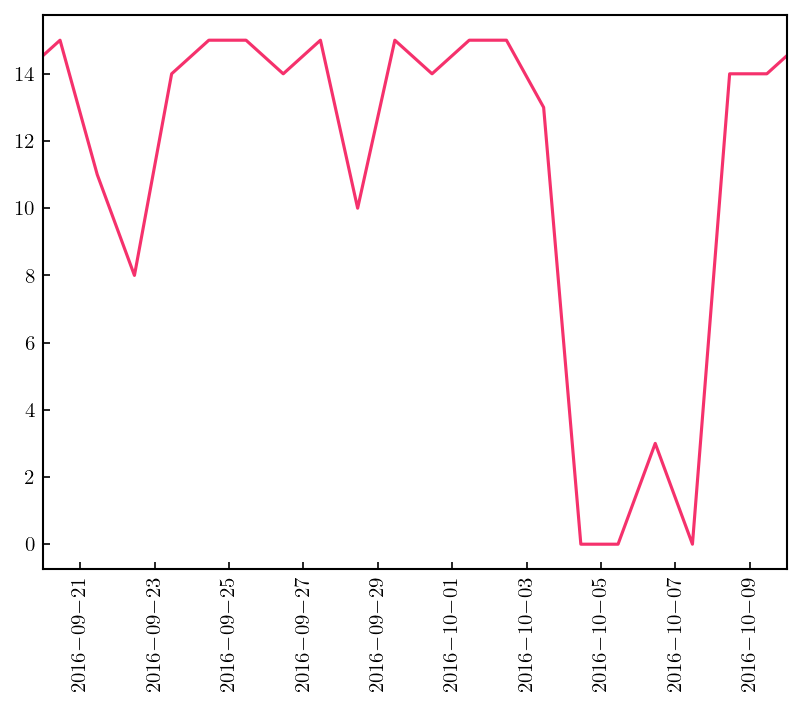

In [17]:
plot_collocation_availability(files)
plt.xlim(np.datetime64("2016-09-20"), np.datetime64("2016-10-10"))
for lbl in plt.gca().xaxis.get_ticklabels():
    lbl.set_rotation(90)

In [18]:
sensors = {}
from tqdm import tqdm
for path in tqdm(files):
    with xr.open_dataset(path) as data:
        try:
            year = path.name.split("_")[1][:4]
            snsrs = [fname.split("_")[2] for fname in data.attrs["input_files"]]
            sensors[year] = sensors.get(year, set()).union(snsrs)
        except Exception:
            pass
        

 13%|███████████▏                                                                        | 4849/36246 [04:43<30:37, 17.08it/s]


KeyboardInterrupt: 

In [19]:
from pansat.environment import get_index
from pansat.products.satellite.ncei import patmosx

In [20]:
ind = get_index(patmosx)

Found table named 'MODIS_Aqua_MYD06_L2' in database but could not load find a corresponding pansat product.
Found table named 'MODIS_Aqua_MYD03' in database but could not load find a corresponding pansat product.
Found table named 'MODIS_Aqua_MYD021KM' in database but could not load find a corresponding pansat product.
Found table named 'MODIS_Aqua_MYD06_L2' in database but could not load find a corresponding pansat product.
Found table named 'MODIS_Aqua_MYD021KM' in database but could not load find a corresponding pansat product.
Found table named 'MODIS_Aqua_MYD03' in database but could not load find a corresponding pansat product.


In [21]:
from pansat import TimeRange
time_range = TimeRange("2010-03-25T10:00:00")

In [22]:
ind.find(time_range)

[Granule(filename='patmosx_v06r00_NOAA-19_des_d20100325_c20210727_v2.zarr', start_time='2010-03-25 00:00:00', end_time='2010-03-25 23:59:59', primary_index_name='', primary_index_range='(-1, -1)'),
 Granule(filename='patmosx_v06r00_METOP-A_des_d20100325_c20210730_v2.zarr', start_time='2010-03-25 00:00:00', end_time='2010-03-25 23:59:59', primary_index_name='', primary_index_range='(-1, -1)'),
 Granule(filename='patmosx_v06r00_NOAA-18_asc_d20100325_c20210812_v2.zarr', start_time='2010-03-25 00:00:00', end_time='2010-03-25 23:59:59', primary_index_name='', primary_index_range='(-1, -1)'),
 Granule(filename='patmosx_v06r00_NOAA-19_asc_d20100325_c20210727_v2.zarr', start_time='2010-03-25 00:00:00', end_time='2010-03-25 23:59:59', primary_index_name='', primary_index_range='(-1, -1)'),
 Granule(filename='patmosx_v06r00_METOP-A_asc_d20100325_c20210730_v2.zarr', start_time='2010-03-25 00:00:00', end_time='2010-03-25 23:59:59', primary_index_name='', primary_index_range='(-1, -1)'),
 Granule(f

In [23]:
data = xr.load_dataset("/scratch/ccic_record/collocations/patmosx_new/patmosx_20100325120744_20783.nc")

## MODIS

Just as ISCCP and PATMOS-x, the standard MODIS water path retrievals are limited to cloudy day-time pixels. For MODIS, however, the ``cloud_phase`` variable can be used to distinguish day-time from night-time results.

A special issue with the MODIS collocations, which are derived from the MOD06-1km-AUX product is that the latitude coordinate does not match those of CloudSat identically and thus the extraction of rays within the latitude bounds leads to inconsistent number of profiles with respect to the CloudSat/CCIC collocations. The ``get_tiwp_modis`` therefore use ``time`` as dimension to allow for interpolating of the data to the CloudSat/CCIC collocations.

In [24]:
def get_tiwp_modis(dataset: xr.Dataset) -> xr.DataArray:
    """
    Determine MODIS TIWP from collocations file.

    Args:
        dataset: A xarray.Dataset containing MODIS collocations.

    Return:
        A DataArray containing the extracted TIWP
    """
    dataset = dataset[{"modis_pixels": 7}]
    valid_rays = (LAT_LIMITS[0] < dataset.latitude.data) * (dataset.latitude.data < LAT_LIMITS[1])
    dataset = dataset[{"rays": valid_rays}]
    
    valid = np.concatenate([[True], np.diff(dataset.time.data) > np.timedelta64(0, "ns")], 0)
    dataset = dataset[{"rays": valid}]
                           
    cloud_phase = dataset.cloud_phase
    cloud_water_path = dataset.cloud_water_path
    # Mask values with undertermined cloud phase.
    ice_mask = cloud_phase.data == 3
    tiwp = np.zeros(dataset.rays.size, dtype="float32")
    tiwp[ice_mask] = dataset.cloud_water_path.data[ice_mask] / 1e3
    tiwp[tiwp < 0] = np.nan
    tiwp[cloud_phase.data <= 0] = np.nan
    tiwp[cloud_phase.data == 4] = np.nan
    
    return xr.DataArray(
        tiwp,
        dims=("time",),
        coords = {
            "time": (("time",), dataset.time.data),
            "latitude": (("time",), dataset.latitude.data),
            "longitude": (("time"), dataset.longitude.data),
        }
    )

2006-06-02T13:42:29.000000000 2017-12-05T14:11:07.000000000
['2006-06-02T13:42:29.000000000' '2006-06-03T13:42:29.000000000'
 '2006-06-04T13:42:29.000000000' ... '2017-12-03T13:42:29.000000000'
 '2017-12-04T13:42:29.000000000' '2017-12-05T13:42:29.000000000']


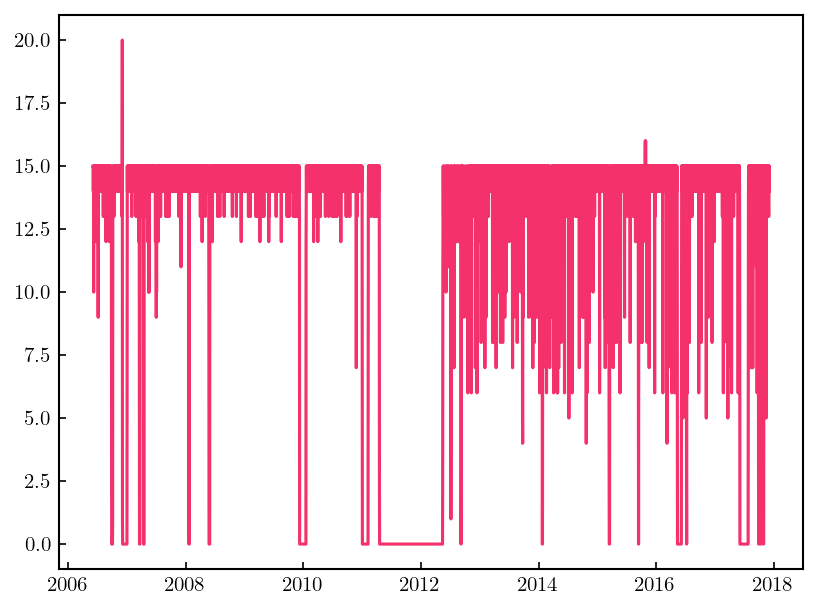

In [25]:
files = sorted(list(Path("/scratch/ccic_record/collocations/modis").glob("*.nc")))
plot_collocation_availability(files)

# ERA5

In [26]:
def get_tiwp_era5(dataset: xr.Dataset) -> xr.DataArray:
    """
    Determine ERA5 TIWP from collocations file.

    Args:
        dataset: A xarray.Dataset containing ERA5 collocations.

    Return:
        A DataArray containing the extracted TIWP
    """
    valid_rays = (LAT_LIMITS[0] < dataset.latitude.data) * (dataset.latitude.data < LAT_LIMITS[1])
    dataset = dataset[{"rays": valid_rays}]
    tiwp = dataset["__xarray_dataarray_variable__"].reset_index("rays").drop_vars("rays")
    return tiwp


2006-06-12T20:55:32.000000000 2020-08-26T17:45:33.000000000
['2006-06-12T20:55:32.000000000' '2006-06-13T20:55:32.000000000'
 '2006-06-14T20:55:32.000000000' ... '2020-08-23T20:55:32.000000000'
 '2020-08-24T20:55:32.000000000' '2020-08-25T20:55:32.000000000']


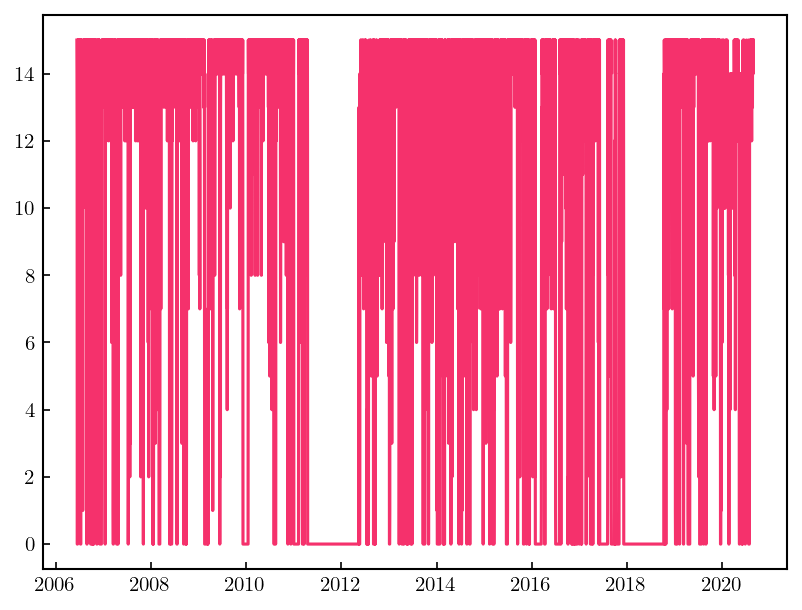

In [27]:
files = sorted(list(Path("/scratch/ccic_record/era5_collocations/updated/").glob("*.nc")))
plot_collocation_availability(files)

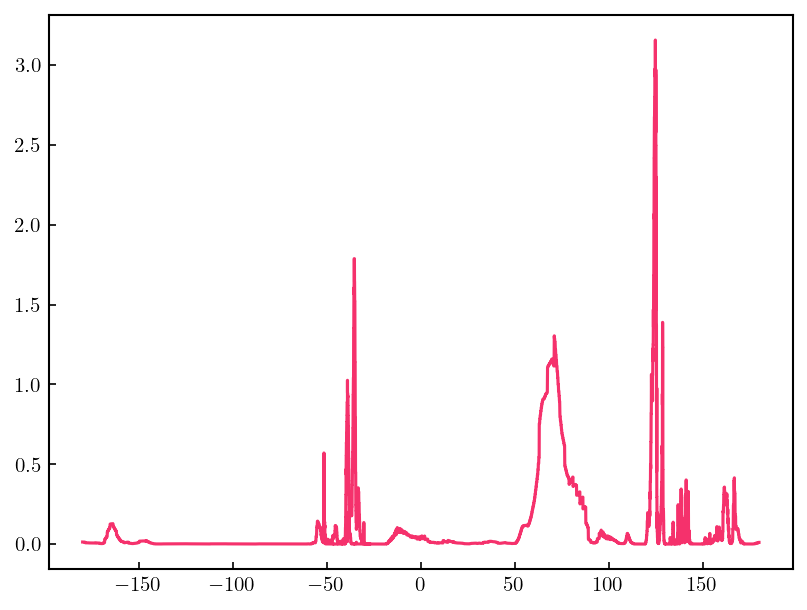

In [28]:
data = xr.load_dataset(files[4])
plt.plot(data.longitude, data.__xarray_dataarray_variable__)

## CCIC (CPCIR)

In [29]:
def get_tiwp_ccic_cpcir(dataset: xr.Dataset) -> xr.DataArray:
    """
    Determine TIWP from CCIC (CPCIR) collocation file.

    Args:
        dataset: A xarray.Dataset containing CCIC (CPCIR) collocations.

    Return:
        A DataArray containing the extracted TIWP
    """
    valid_rays = (LAT_LIMITS[0] < dataset.latitude.data) * (dataset.latitude.data < LAT_LIMITS[1])
    dataset = dataset[{"rays": valid_rays}]
    tiwp = dataset["tiwp"].reset_index("rays").drop_vars("rays")
    return tiwp

## CCIC (GridSat)

In [30]:
def get_tiwp_ccic_gridsat(dataset: xr.Dataset) -> xr.DataArray:
    """
    Determine TIWP from CCIC (GridSat) collocation file.

    Args:
        dataset: A xarray.Dataset containing CCIC (CPCIR) collocations.

    Return:
        A DataArray containing the extracted TIWP
    """
    valid_rays = (LAT_LIMITS[0] < dataset.latitude.data) * (dataset.latitude.data < LAT_LIMITS[1])
    dataset = dataset[{"rays": valid_rays}]
    tiwp = dataset["tiwp"].reset_index("rays").drop_vars("rays")
    return tiwp

2006-06-12T20:55:32.000000000 2020-08-26T17:45:33.000000000
['2006-06-12T20:55:32.000000000' '2006-06-13T20:55:32.000000000'
 '2006-06-14T20:55:32.000000000' ... '2020-08-23T20:55:32.000000000'
 '2020-08-24T20:55:32.000000000' '2020-08-25T20:55:32.000000000']


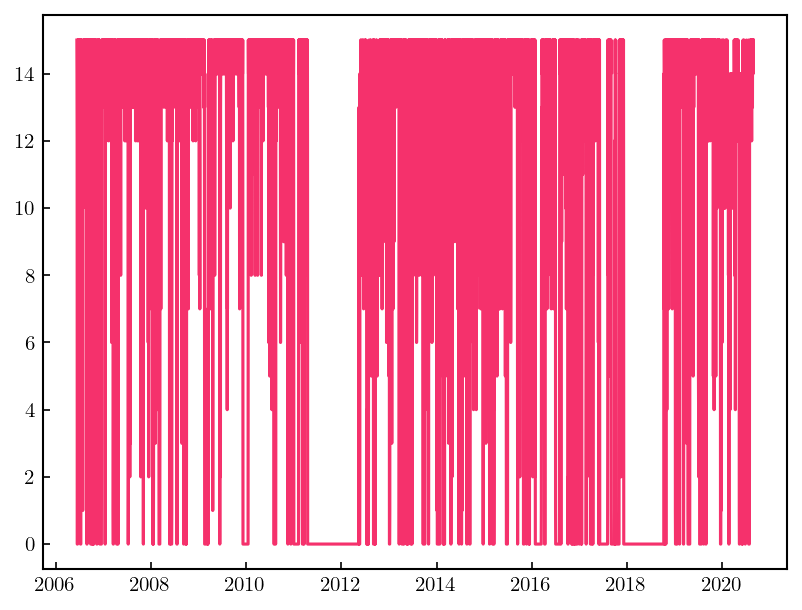

In [31]:
files = sorted(list(Path("/scratch/ccic_record/era5_collocations/updated/").glob("*.nc")))
plot_collocation_availability(files)

## Combine data

In [32]:
def find_granules(path: Path) -> Dict[int, Path]:
    """
    Compile dictionary mapping granules to filenames.

    Args:
        path: A path object pointing to a directory containing CloudSat collocations.

    Return:
        A dictionary mapping granule number to corresponding collocations files.
    """
    path = Path(path)
    files = sorted(list(path.glob("*.nc")))
    granules = {}
    for path in files:
        granule = int(path.name.split("_")[-1][:-3])
        granules[granule] = path
    return granules


In [33]:
modis_granules = find_granules("/scratch/ccic_record//collocations/modis/")
isccp_granules = find_granules("/scratch/ccic_record//collocations/isccp")
patmosx_granules = find_granules("/scratch/ccic_record/collocations/patmosx_rev")
cloudsat_granules = find_granules("/scratch/ccic_record/data/cloudsat/cloudsat_collocations")
era5_granules = find_granules("/scratch/ccic_record/era5_collocations/updated/")
ccic_cpcir_granules = find_granules("/scratch/ccic_record/collocations/cpcir")
ccic_gridsat_granules = find_granules("/scratch/ccic_record/collocations/gridsat")
common = (
    set(modis_granules).intersection(isccp_granules).intersection(cloudsat_granules)
    .intersection(patmosx_granules).intersection(ccic_cpcir_granules).intersection(era5_granules)
)
print(f"Found {len(common)} collocation files.")

Found 30422 collocation files.


In [34]:
list(patmosx_granules.values())[-5000]

PosixPath('/scratch/ccic_record/collocations/patmosx_rev/patmosx_20170808154314_60007.nc')

In [35]:
res_1 = xr.load_dataset('/scratch/ccic_record/collocations/patmosx_rev/patmosx_20170808154314_60007.nc')

In [36]:
res_2 = xr.load_dataset('/scratch/ccic_record/collocations/patmosx_new/patmosx_20170808154314_60007.nc')

(-180.0, 180.0)

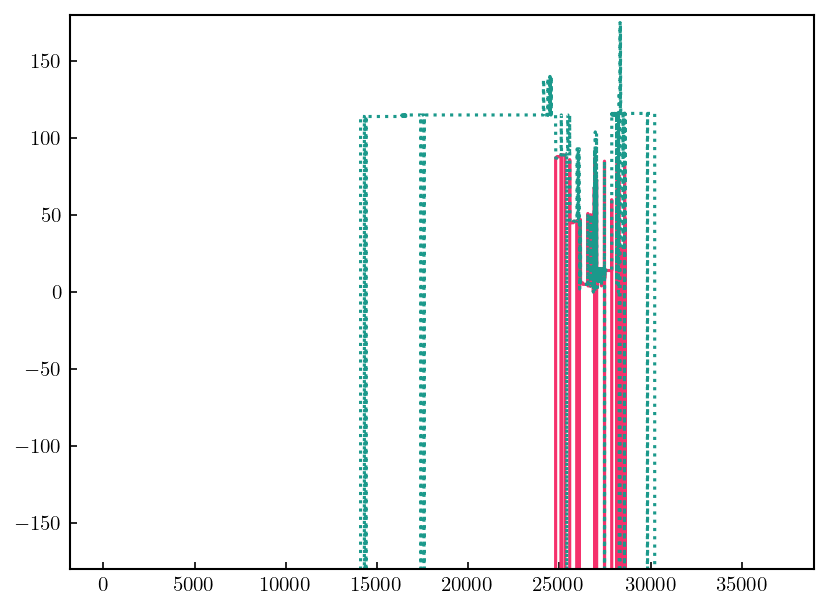

In [37]:
plt.plot(np.abs(res_1.scan_line_time - res_1.cs_time) / 1e9 / 60)
plt.plot(np.abs(res_2.scan_line_time - res_2.cs_time) / 1e9 / 60, ls=":")
plt.ylim(-180, 180)

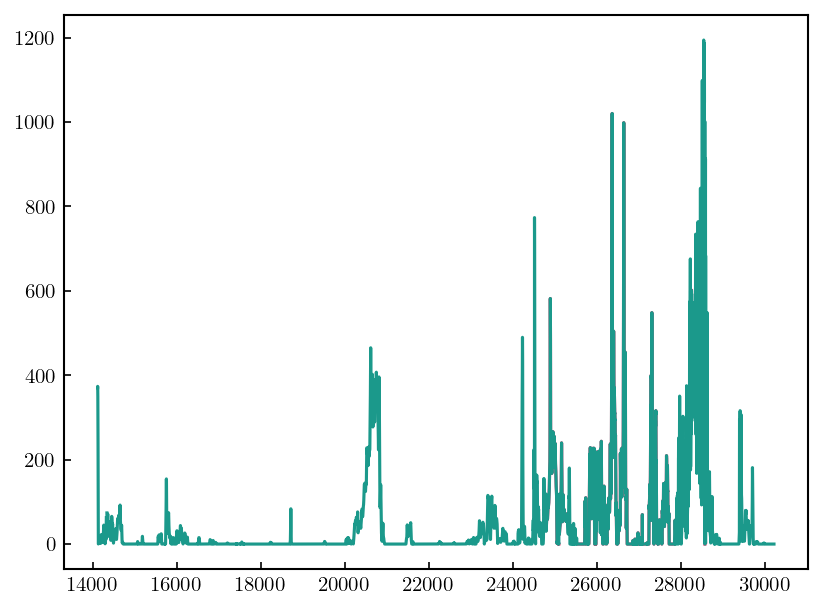

In [38]:
plt.plot(res_1.cld_iwp_dcomp, label="Res 1")
plt.plot(res_2.cld_iwp_dcomp, label="Res 2")

In [39]:
res_1 = xr.load_dataset(list(patmosx_granules)[0])

ValueError: did not find a match in any of xarray's currently installed IO backends ['netcdf4', 'h5netcdf', 'scipy', 'zarr']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html

In [ ]:
patmosx_res_1 = xr.load_dataset("/scratch/ccic_record/collocations/patmosx_new/

In [40]:
%rm -rf /scratch/ccic_record/data/collocations/combined

^C


In [41]:
%mkdir /scratch/ccic_record/data/collocations/combined

mkdir: cannot create directory ‘/scratch/ccic_record/data/collocations/combined’: File exists


In [ ]:
from concurrent.futures import ProcessPoolExecutor
import logging
from tqdm import tqdm
from pansat.time import to_datetime

LOGGER = logging.getLogger("log")

output_path = Path("/scratch/ccic_record/data/collocations/combined")
output_path.mkdir(exist_ok=True)

def process_granule(granule):
    try:
        cs_data = xr.load_dataset(cloudsat_granules[granule])
        data = cs_data.rename(
            iwp_ccic="tiwp_ccic_gridsat_old",
            iwp_2cice="tiwp_2cice",
            iwp_dardar="tiwp_dardar"
        )
        data["tiwp_modis"] = get_tiwp_modis(xr.load_dataset(modis_granules[granule])).interp(time=cs_data.time)
        data["tiwp_isccp"] = get_tiwp_isccp(xr.load_dataset(isccp_granules[granule]))
        data["tiwp_patmosx"] = get_tiwp_patmosx(xr.load_dataset(patmosx_granules[granule]))
        data["tiwp_era5"] = get_tiwp_era5(xr.load_dataset(era5_granules[granule]))
        data["tiwp_ccic_cpcir"] = get_tiwp_ccic_cpcir(xr.load_dataset(ccic_cpcir_granules[granule]))
        data["tiwp_ccic_gridsat"] = get_tiwp_ccic_gridsat(xr.load_dataset(ccic_gridsat_granules[granule]))
        start_time = to_datetime(data.time[0].data)
        time_str = start_time.strftime("%Y%m%d%H%M%S")
        filename = f"cloudsat_collocations_{time_str}_{granule}.nc"
        data.to_netcdf(output_path / filename)
    except Exception:
        LOGGER.exception(f"Encountered error processing granule {granule}.")

pool = ProcessPoolExecutor(max_workers=32)

tasks = []
for granule in sorted(list(common)):
    tasks.append(pool.submit(process_granule, granule))

for task in tqdm(tasks):
    task.result()


Encountered error processing granule 14251.
Traceback (most recent call last):
  File "/tmp/ipykernel_2850923/3176221682.py", line 19, in process_granule
    data["tiwp_modis"] = get_tiwp_modis(xr.load_dataset(modis_granules[granule])).interp(time=cs_data.time)
  File "/scratch/spfrnd/micromamba/envs/ccic_record/lib/python3.10/site-packages/xarray/core/dataarray.py", line 2341, in interp
    ds = self._to_temp_dataset().interp(
  File "/scratch/spfrnd/micromamba/envs/ccic_record/lib/python3.10/site-packages/xarray/core/dataset.py", line 4050, in interp
    obj, newidx = missing._localize(obj, {k: v})
  File "/scratch/spfrnd/micromamba/envs/ccic_record/lib/python3.10/site-packages/xarray/core/missing.py", line 562, in _localize
    imin, imax = index.get_indexer([minval, maxval], method="nearest")
  File "/scratch/spfrnd/micromamba/envs/ccic_record/lib/python3.10/site-packages/pandas/core/indexes/base.py", line 3885, in get_indexer
    raise InvalidIndexError(self._requires_unique_msg)


## Plot combined data

In [89]:
combined_files = list(Path("/scratch/ccic_record/data/collocations/combined/").glob("*.nc"))

In [90]:
ind = 33
data = xr.load_dataset(combined_files[ind])

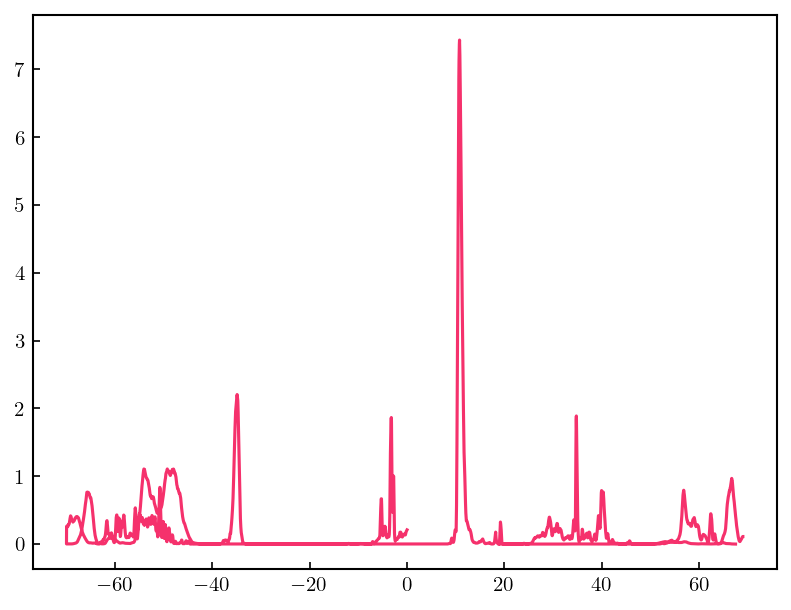

In [94]:
plt.plot(data.latitude, data.tiwp_ccic_gridsat)

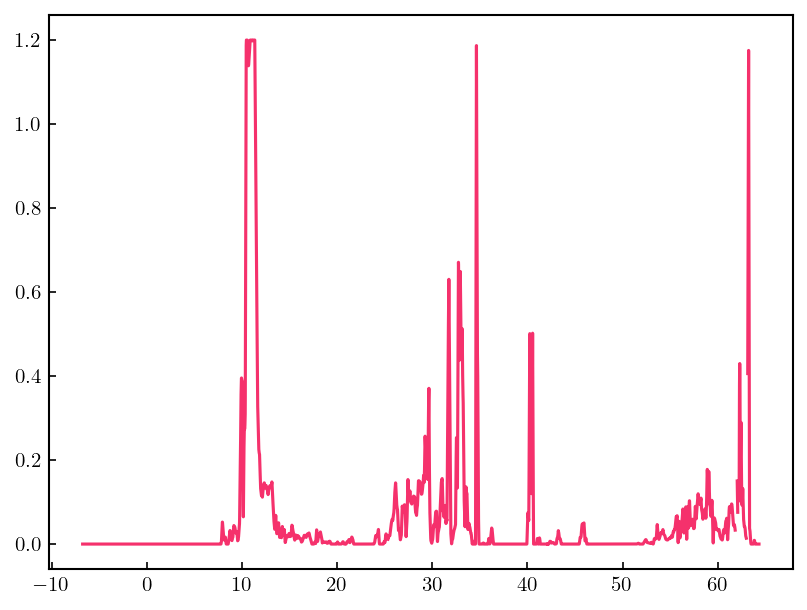

In [92]:
plt.plot(data.latitude, data.tiwp_patmosx)

In [46]:
data.longitude

<xarray.DataArray 'longitude' (rays: 29265)> Size: 117kB
array([94.890945, 94.88889 , 94.88683 , ..., 70.17671 , 70.17465 ,
       70.1726  ], dtype=float32)
Coordinates:
  * rays               (rays) int64 234kB 0 1 2 3 4 ... 29261 29262 29263 29264
    longitude          (rays) float32 117kB 94.89 94.89 94.89 ... 70.17 70.17
    latitude           (rays) float32 117kB -0.008348 -0.01801 ... 0.001384
    time               (rays) datetime64[ns] 234kB 2016-11-05T19:26:15.367187...
    surface_elevation  (rays) int64 234kB -9999 -9999 -9999 ... -9999 -9999

0.4218039929167918


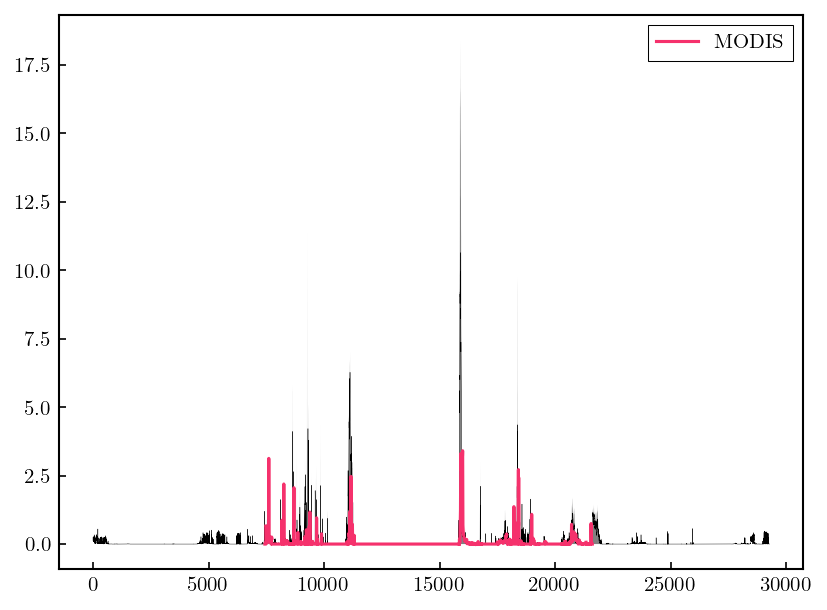

In [44]:
plt.fill_between(data.rays, y1=0, y2=data.tiwp_2cice, facecolor="grey", zorder=0)
plt.plot(data.rays, data.tiwp_dardar, c="k", lw=0.2, zorder=1)
#plt.plot(data.rays, data.tiwp_patmosx / 1e3, label="PASTMOS-x")
plt.plot(data.rays, data.tiwp_modis, label="MODIS")
#plt.plot(data.rays, data.tiwp_ccic_gridsat, label="CCIC (GridSat)")
#plt.plot(data.rays, data.tiwp_ccic_cpcir, label="CCIC (CPCIR)")
#plt.plot(data.rays, data.tiwp_era5, label="ERA5")
tiwp_modis = data.tiwp_modis.data
tiwp_dardar = data.tiwp_dardar.data
valid = np.isfinite(tiwp_modis) * np.isfinite(tiwp_dardar)
print(np.corrcoef(tiwp_modis[valid], tiwp_dardar[valid])[0, 1])
plt.legend()

## Aggregate results

In [95]:
from filelock import FileLock
from scipy.stats import binned_statistic_2d
from pansat.time import to_datetime
from filelock import FileLock

ref_product = "2cice"
products = ["2cice", "dardar", "modis", "isccp", "patmosx", "ccic_gridsat", "ccic_gridsat_old", "ccic_cpcir", "era5"]
bins = np.logspace(-3, np.log10(30), 101)

N_LATS = 180
LAT_BINS = np.linspace(-90, 90, N_LATS + 1)

def create_dataset():
    dataset = {}
    dims = ("latitude", "longitude")
    dataset["zonal_dist"] = np.zeros(N_LATS)
    for prod in products:
        dataset[f"tiwp_{prod}_sum"] = 0.0
        dataset[f"tiwp_{prod}_sqrsum"] = 0.0
        dataset[f"tiwp_{prod}_2cice_sum"] = 0.0
        dataset[f"tiwp_{prod}_dardar_sum"] = 0.0
        dataset[f"bins_boundaries"] = (("bin_boundaries"), bins)
        dataset[f"dist_{prod}_2cice"] = (("bins_1", "bins_2"), np.zeros((100, 100)))
        dataset[f"dist_{prod}_dardar"] = (("bins_1", "bins_2"), np.zeros((100, 100)))
        
    dataset["counts"] = 0.0
    return xr.Dataset(dataset)
    

def calculate_aggregate_stats(
    path: Path,
    output_path: Path
) -> None:
    """
    Calculates aggregate statistics on daily scales.

    Calculates sums and squared sums of the TIWP from all assessed products on daily scales. These
    can be used to calculate Bias, MSE, and correlation.

    Args:
        path: A Path object pointing to a file containing the combined TIWP from all assessed products.
        output_path: The path to which to write the results
    """
    colloc_data = xr.load_dataset(path)
    daytime_flag = np.isfinite(colloc_data.cloud_mask_2cice.data)
    time = colloc_data.time.data
    year = colloc_data.time.dt.year.data
    month = colloc_data.time.dt.month.data
    day = colloc_data.time.dt.day.data

    for ud in np.unique(day):
        time_mask = day == ud
        yr = year[time_mask][0]
        mnth = month[time_mask][0]
        filename = f"cloudsat_collocations_{yr:04}{mnth:02}{ud:02}.nc"
        output_file = output_path / filename

        lock = FileLock(output_path / (filename + ".lock"))
        with lock:
            if output_file.exists():
                dataset = xr.load_dataset(output_file)
            else:
                dataset = create_dataset()

            valid = time_mask * daytime_flag
            for prod in products:
                valid *= np.isfinite(colloc_data[f"tiwp_{prod}"].data)
            valid *= colloc_data["tiwp_dardar"].data < 1e3
            if valid.sum() == 0:
                continue
            
            data = colloc_data[{"rays": valid}]
            lons = data.longitude.data
            lats = data.latitude.data
            dataset["time"] = data.time.data[0].astype("datetime64[D]").astype("datetime64[ns]")

            tiwp_2cice = data["tiwp_2cice"]
            tiwp_dardar = data["tiwp_dardar"]
            
            for prod in products:
                tiwp_p = data[f"tiwp_{prod}"].data
                dataset[f"tiwp_{prod}_sum"] += tiwp_p.sum()
                dataset[f"tiwp_{prod}_sqrsum"] += (tiwp_p ** 2).sum()
                dataset[f"tiwp_{prod}_2cice_sum"] += (tiwp_p * tiwp_2cice).sum()
                dataset[f"tiwp_{prod}_dardar_sum"] += (tiwp_p * tiwp_dardar).sum()
                dataset[f"dist_{prod}_2cice"] += np.histogram2d(tiwp_2cice, tiwp_p, bins=bins)[0]
                dataset[f"dist_{prod}_dardar"] += np.histogram2d(tiwp_dardar, tiwp_p, bins=bins)[0]

            dataset["counts"] += valid.sum()
            dataset["zonal_dist"] = np.histogram(data.latitude.data, bins=LAT_BINS)[0]
            dataset.to_netcdf(output_file)


In [96]:
rm /scratch/ccic_record/data/collocations/daily/*.nc

In [ ]:
from concurrent.futures import ProcessPoolExecutor
from tqdm import tqdm

files_cmb = np.random.permutation(list(Path("/scratch/ccic_record/data/collocations/combined").glob("*.nc")))
output_path = Path("/scratch/ccic_record/data/collocations/daily")
pool = ProcessPoolExecutor(max_workers=32)

tasks = []
for path in files_cmb:
    tasks.append(pool.submit(calculate_aggregate_stats, path, output_path))

for task, cmb_file in tqdm(list(zip(tasks, files_cmb))):
    try:
        task.result()
    except Exception as exc:
        
        print("Error reading file: ", cmb_file)
        raise exc
        pass

 43%|███████████████████████████████████▏                                              | 12424/28930 [03:38<02:19, 118.69it/s]

In [58]:
daily_stats[0]

<xarray.Dataset> Size: 1MB
Dimensions:                           (zonal_dist: 180, bin_boundaries: 101,
                                       bins_1: 100, bins_2: 100)
Coordinates:
  * zonal_dist                        (zonal_dist) int64 1kB 0 0 0 0 ... 0 0 0 0
Dimensions without coordinates: bin_boundaries, bins_1, bins_2
Data variables: (12/57)
    tiwp_2cice_sum                    float64 8B 3.513e+03
    tiwp_2cice_sqrsum                 float64 8B 1.054e+04
    tiwp_2cice_2cice_sum              float64 8B 1.054e+04
    tiwp_2cice_dardar_sum             float64 8B 7.528e+03
    bins_boundaries                   (bin_boundaries) float64 808B 0.001 ......
    dist_2cice_2cice                  (bins_1, bins_2) float64 80kB 144.0 ......
    ...                                ...
    tiwp_era5_2cice_sum               float64 8B 669.1
    tiwp_era5_dardar_sum              float64 8B 541.7
    dist_era5_2cice                   (bins_1, bins_2) float64 80kB 0.0 ... 0.0
    dist_era5_dardar                  (bins_1, bins_2) float64 80kB 2.0 ... 0.0
    counts                            float64 8B 4.368e+04
    time                              datetime64[ns] 8B 2009-04-14

In [63]:
data.reset_index("zonal_dist")

<xarray.Dataset> Size: 1MB
Dimensions:                           (zonal_dist: 180, bin_boundaries: 101,
                                       bins_1: 100, bins_2: 100)
Coordinates:
    zonal_dist                        (zonal_dist) int64 1kB 0 0 0 0 ... 0 0 0 0
Dimensions without coordinates: bin_boundaries, bins_1, bins_2
Data variables: (12/57)
    tiwp_2cice_sum                    float64 8B 2.651e+03
    tiwp_2cice_sqrsum                 float64 8B 6.33e+03
    tiwp_2cice_2cice_sum              float64 8B 6.33e+03
    tiwp_2cice_dardar_sum             float64 8B 5.166e+03
    bins_boundaries                   (bin_boundaries) float64 808B 0.001 ......
    dist_2cice_2cice                  (bins_1, bins_2) float64 80kB 157.0 ......
    ...                                ...
    tiwp_era5_2cice_sum               float64 8B 1.745e+03
    tiwp_era5_dardar_sum              float64 8B 1.442e+03
    dist_era5_2cice                   (bins_1, bins_2) float64 80kB 0.0 ... 0.0
    dist_era5_dardar                  (bins_1, bins_2) float64 80kB 1.0 ... 0.0
    counts                            float64 8B 2.896e+04
    time                              datetime64[ns] 8B 2017-06-04

In [64]:
daily_files = sorted(list(Path("/scratch/ccic_record/data/collocations/daily").glob("*.nc")))
daily_stats = []
for daily_file in tqdm(daily_files):
    try:
        data = xr.load_dataset(daily_file).reset_index("zonal_dist")
        daily_stats.append(data)
    except Exception:
        print(f"Failed loading {daily_file}.")
daily_stats = xr.concat(daily_stats, dim="time")

100%|█████████████████████████████████████████████████████████████████████████████████████| 2209/2209 [00:41<00:00, 53.03it/s]
/scratch/spfrnd/micromamba/envs/ccic_record/lib/python3.10/site-packages/xarray/core/dataset.py:4789: UserWarning: No index created for dimension time because variable time is not a coordinate. To create an index for time, please first call `.set_coords('time')` on this object.
  warnings.warn(


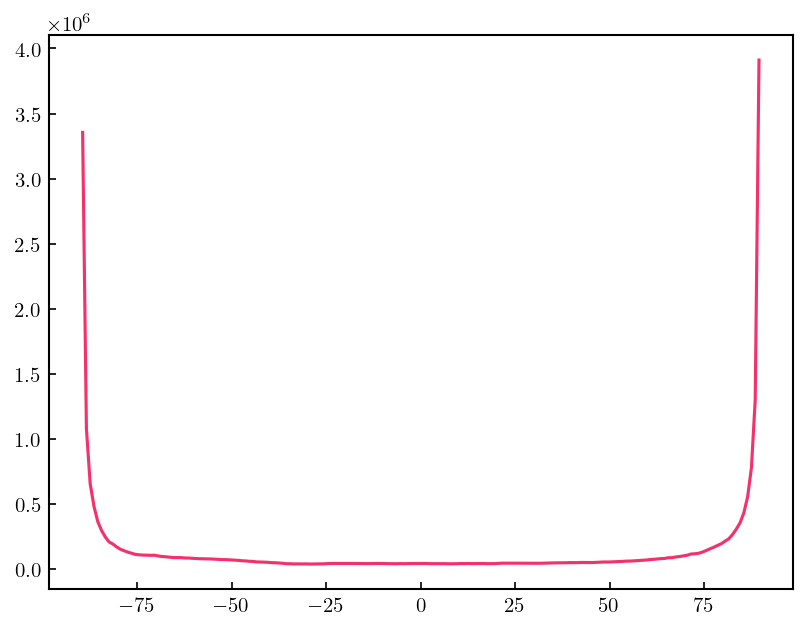

In [88]:
x = 0.5 * (LAT_BINS[1:] + LAT_BINS[:-1])
plt.plot(x, daily_stats.zonal_dist.sum("time") / np.cos(np.deg2rad(x)))

## Filter invalid DARDAR data

The DARDAR data contain some extremely high values that throw off the analysis. They are removed below.

In [70]:
valid = daily_stats.tiwp_dardar_sum < 1e10
daily_stats = daily_stats[{"time": valid}]
print(f"Removed {(~valid.data).sum()} days.")

Removed 0 days.


## Time series

In [71]:
products = ["2cice", "dardar", "modis", "isccp", "patmosx", "ccic_gridsat", "ccic_cpcir", "era5"]
monthly_means_full = {}
monthly_means_full[f"counts"] = daily_stats["counts"].resample(time="1ME").sum()
for prod in products:
    monthly_means_full[f"tiwp_{prod}"] = daily_stats[f"tiwp_{prod}_sum"].resample(time="1ME").sum() / monthly_means_full["counts"]
monthly_means_full = xr.Dataset(monthly_means_full)

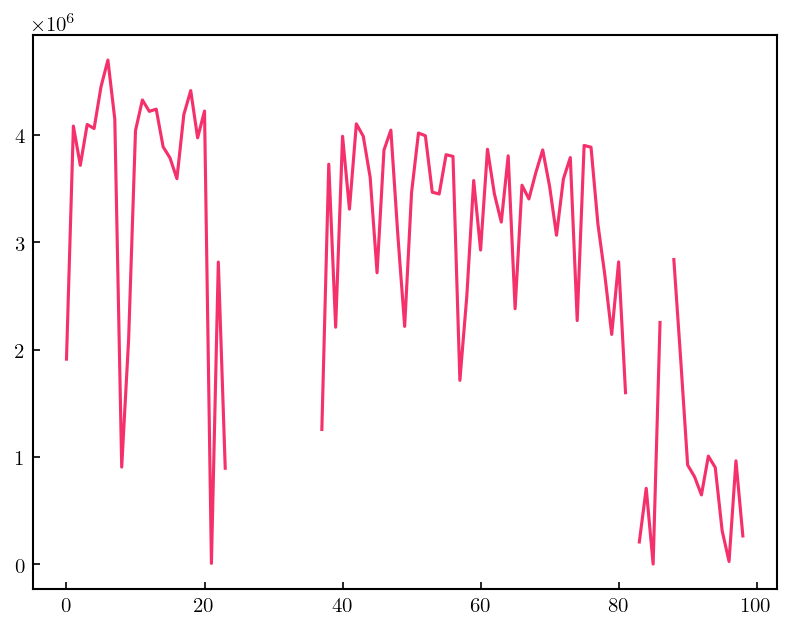

In [72]:
plt.plot(monthly_means_full["counts"])

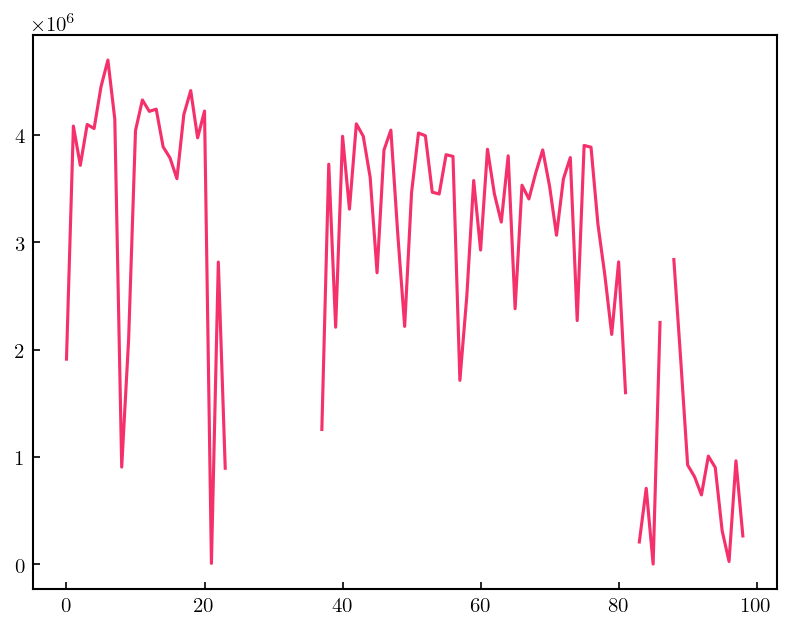

In [73]:
plt.plot(monthly_means_full["counts"])

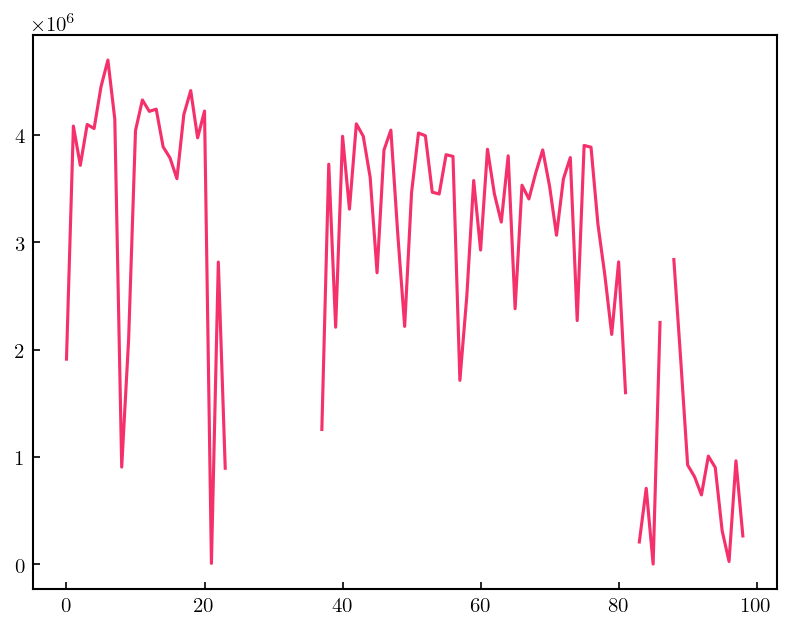

In [74]:
plt.plot(monthly_means_full["counts"])

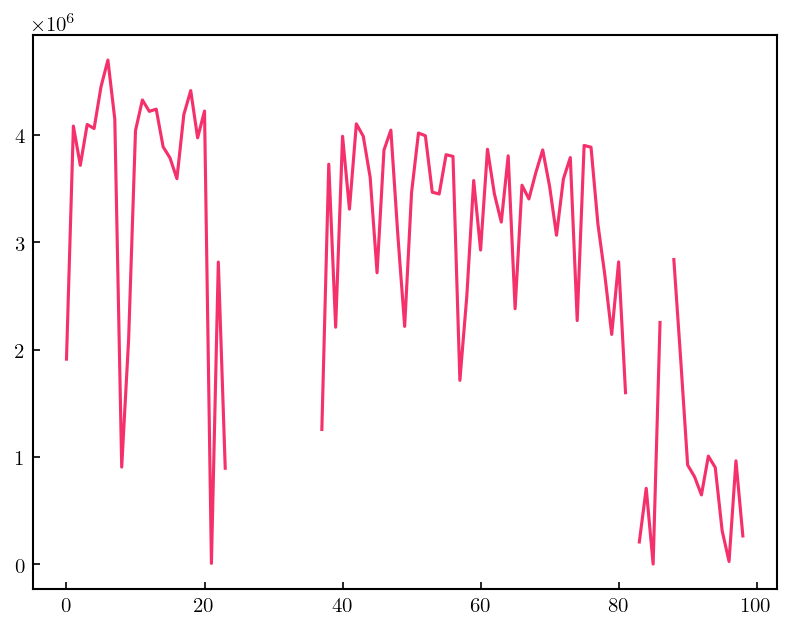

In [75]:
plt.plot(monthly_means_full["counts"])

In [76]:
invalid = monthly_means_full["counts"] < 1e5
for prod in products:
    monthly_means_full[f"tiwp_{prod}"][invalid] = np.nan

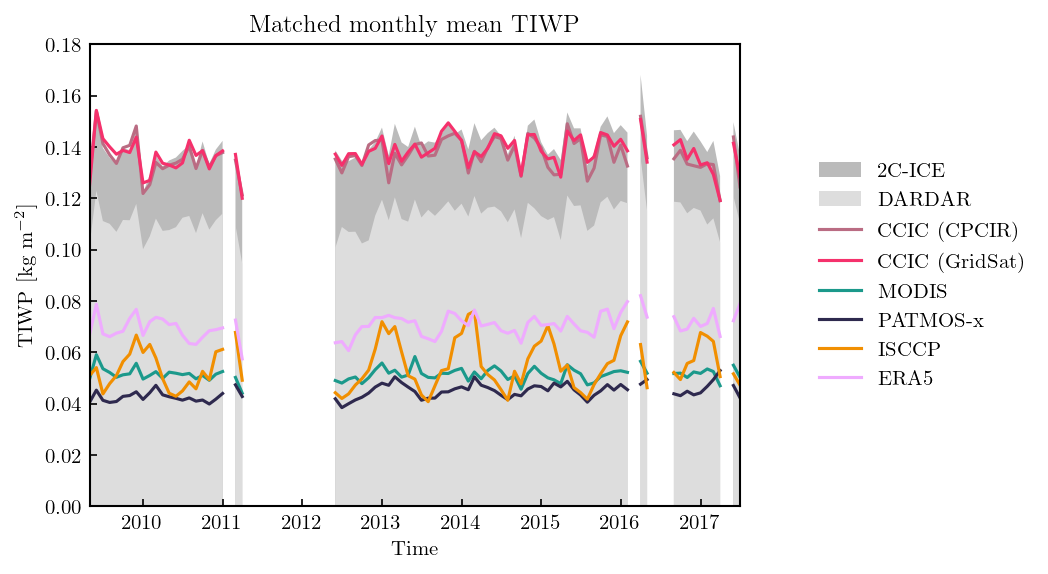

In [77]:
from matplotlib.gridspec import GridSpec
from matplotlib.colors import to_rgba
import seaborn as sns

fig = plt.figure(figsize=(8, 4))
gs = GridSpec(1, 2, width_ratios=[1.0, 0.3])

ax = fig.add_subplot(gs[0, 0])

handles = []

sns.reset_orig()
c0 = sns.desaturate(to_rgba("#f5316c"), 0.4)

handles.append(ax.fill_between(monthly_means_full.time, 0, monthly_means_full.tiwp_2cice, facecolor="#bbbbbb", label="2C-ICE"))
handles.append(ax.fill_between(monthly_means_full.time, 0, monthly_means_full.tiwp_dardar, facecolor="#dddddd", label="DARDAR"))
handles += ax.plot(monthly_means_full.time, monthly_means_full.tiwp_ccic_cpcir, c=c0, label="CCIC (CPCIR)")
handles += ax.plot(monthly_means_full.time, monthly_means_full.tiwp_ccic_gridsat, c="C0", label="CCIC (GridSat)")
handles += ax.plot(monthly_means_full.time, monthly_means_full.tiwp_modis, c="C1", label="MODIS")
handles += ax.plot(monthly_means_full.time, monthly_means_full.tiwp_patmosx, c="C2", label="PATMOS-x")
handles += ax.plot(monthly_means_full.time, monthly_means_full.tiwp_isccp, c="C3", label="ISCCP")
handles += ax.plot(monthly_means_full.time, monthly_means_full.tiwp_era5, c="C4", label="ERA5")

ax.set_xlim(monthly_means_full.time.data.min(), monthly_means_full.time.data.max())
ax.set_ylim(0, 0.18)
ax.set_ylabel("TIWP [kg m$^{-2}$]")
ax.set_title("Matched monthly mean TIWP", loc="center")
ax.set_xlabel("Time")

ax = fig.add_subplot(gs[0, 1])
ax.set_axis_off()
ax.legend(handles=handles, loc="center", frameon=False)
fig.savefig("../../figures/matched_monthly_tiwp.pdf")

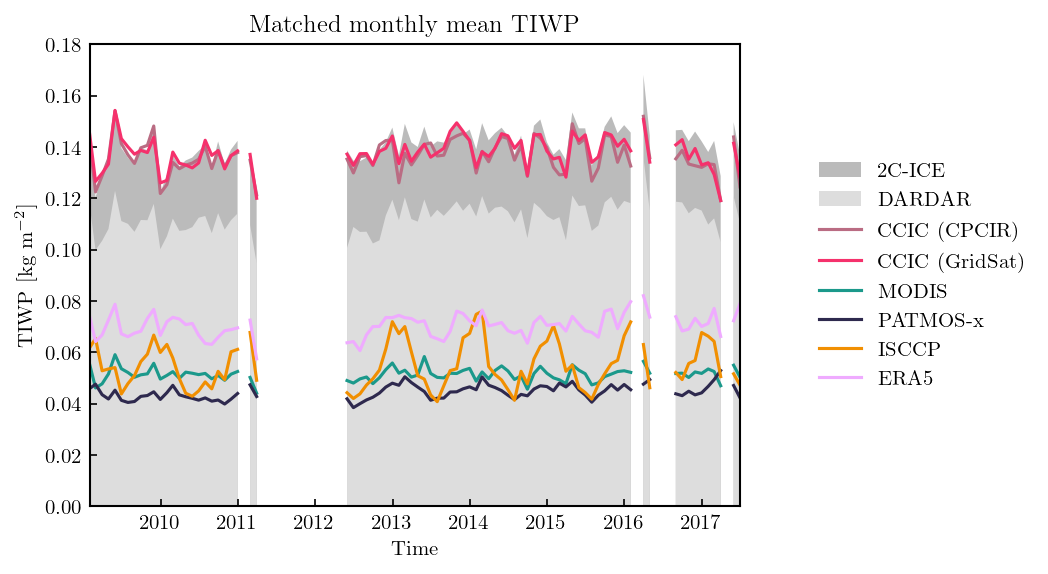

In [28]:
from matplotlib.gridspec import GridSpec
from matplotlib.colors import to_rgba
import seaborn as sns

fig = plt.figure(figsize=(8, 4))
gs = GridSpec(1, 2, width_ratios=[1.0, 0.3])

ax = fig.add_subplot(gs[0, 0])

handles = []

sns.reset_orig()
c0 = sns.desaturate(to_rgba("#f5316c"), 0.4)

handles.append(ax.fill_between(monthly_means_full.time, 0, monthly_means_full.tiwp_2cice, facecolor="#bbbbbb", label="2C-ICE"))
handles.append(ax.fill_between(monthly_means_full.time, 0, monthly_means_full.tiwp_dardar, facecolor="#dddddd", label="DARDAR"))
handles += ax.plot(monthly_means_full.time, monthly_means_full.tiwp_ccic_cpcir, c=c0, label="CCIC (CPCIR)")
handles += ax.plot(monthly_means_full.time, monthly_means_full.tiwp_ccic_gridsat, c="C0", label="CCIC (GridSat)")
handles += ax.plot(monthly_means_full.time, monthly_means_full.tiwp_modis, c="C1", label="MODIS")
handles += ax.plot(monthly_means_full.time, monthly_means_full.tiwp_patmosx, c="C2", label="PATMOS-x")
handles += ax.plot(monthly_means_full.time, monthly_means_full.tiwp_isccp, c="C3", label="ISCCP")
handles += ax.plot(monthly_means_full.time, monthly_means_full.tiwp_era5, c="C4", label="ERA5")

ax.set_xlim(monthly_means_full.time.data.min(), monthly_means_full.time.data.max())
ax.set_ylim(0, 0.18)
ax.set_ylabel("TIWP [kg m$^{-2}$]")
ax.set_title("Matched monthly mean TIWP", loc="center")
ax.set_xlabel("Time")

ax = fig.add_subplot(gs[0, 1])
ax.set_axis_off()
ax.legend(handles=handles, loc="center", frameon=False)
fig.savefig("../../figures/matched_monthly_tiwp.pdf")

## Error metrics
### Instantaneous

In [78]:
valid = daily_stats.time > np.datetime64("2012-01-01")
daily_stats = daily_stats[{"time": valid}]

In [79]:
tot = daily_stats.sum("time")
rmse = {}
corr_coef = {}

for prod in products:
    x_mean = tot[f"tiwp_{prod}_sum"].data / tot["counts"]
    x2_mean = tot[f"tiwp_{prod}_sqrsum"].data / tot["counts"]
    xy_mean = tot[f"tiwp_{prod}_2cice_sum"].data / tot["counts"]
    y2_mean = tot[f"tiwp_2cice_sqrsum"].data / tot["counts"]
    y_mean = tot[f"tiwp_2cice_sum"].data / tot["counts"]
    x_sigma = np.sqrt(x2_mean - x_mean ** 2)
    y_sigma = np.sqrt(y2_mean - y_mean ** 2)
    corr_coef[f"{prod}_2cice"] = (xy_mean - x_mean * y_mean) / (x_sigma * y_sigma)
    rmse[f"{prod}_2cice"] = np.sqrt(x2_mean - 2 * xy_mean + y2_mean)
    
    x_mean = tot[f"tiwp_{prod}_sum"].data / tot["counts"]
    x2_mean = tot[f"tiwp_{prod}_sqrsum"].data / tot["counts"]
    xy_mean = tot[f"tiwp_{prod}_dardar_sum"].data / tot["counts"]
    y2_mean = tot[f"tiwp_dardar_sqrsum"].data / tot["counts"]
    y_mean = tot[f"tiwp_dardar_sum"].data / tot["counts"]
    x_sigma = np.sqrt(x2_mean - x_mean ** 2)
    y_sigma = np.sqrt(y2_mean - y_mean ** 2)
    corr_coef[f"{prod}_dardar"] = (xy_mean - x_mean * y_mean) / (x_sigma * y_sigma)
    rmse[f"{prod}_dardar"] = np.sqrt(x2_mean - 2 * xy_mean + y2_mean)

In [80]:
import pandas as pd

instantaneous = pd.DataFrame({
    "RMSE (2C-ICE)": [rmse[f"{prod}_2cice"].item() for prod in products],
    "Correlation coef (2C-ICE)": [corr_coef[f"{prod}_2cice"].item() for prod in products],
    "RMSE (DARDAR)": [rmse[f"{prod}_dardar"].item() for prod in products],
    "Correlation coef (DARDAR)": [corr_coef[f"{prod}_dardar"].item() for prod in products],
},
    index=products
)
    

In [81]:
instantaneous["Scale"] = "Instantaneous"

In [82]:
print(instantaneous.to_latex(index=False, float_format="%.2f"))

\begin{tabular}{rrrrl}
\toprule
RMSE (2C-ICE) & Correlation coef (2C-ICE) & RMSE (DARDAR) & Correlation coef (DARDAR) & Scale \\
\midrule
0.00 & 1.00 & 0.27 & 0.96 & Instantaneous \\
0.27 & 0.96 & 0.00 & 1.00 & Instantaneous \\
0.68 & 0.41 & 0.49 & 0.43 & Instantaneous \\
0.67 & 0.49 & 0.48 & 0.51 & Instantaneous \\
0.67 & 0.62 & 0.47 & 0.63 & Instantaneous \\
0.56 & 0.66 & 0.44 & 0.66 & Instantaneous \\
0.48 & 0.76 & 0.40 & 0.74 & Instantaneous \\
0.69 & 0.38 & 0.50 & 0.42 & Instantaneous \\
\bottomrule
\end{tabular}



## Daily

In [83]:
daily_means = {}
for prod in products:
    daily_means[f"tiwp_{prod}"] = daily_stats[f"tiwp_{prod}_sum"] / daily_stats["counts"]
daily_means = xr.Dataset(daily_means)

In [84]:
bias = {}
rmse = {}
corr_coef = {}

for prod in products:
    bias[f"{prod}_2cice"] = 100.0 * (daily_means[f"tiwp_{prod}"].mean() - daily_means["tiwp_2cice"].mean()) / daily_means["tiwp_2cice"].mean()
    bias[f"{prod}_dardar"] = 100.0 * (daily_means[f"tiwp_{prod}"].mean() - daily_means["tiwp_dardar"].mean()) / daily_means["tiwp_dardar"].mean()
    rmse[f"{prod}_2cice"] = np.sqrt(((daily_means[f"tiwp_{prod}"] - daily_means["tiwp_2cice"]) ** 2).mean())
    rmse[f"{prod}_dardar"] = np.sqrt(((daily_means[f"tiwp_{prod}"] - daily_means["tiwp_dardar"]) ** 2).mean())
    corr_coef[f"{prod}_2cice"] = np.corrcoef(daily_means[f"tiwp_{prod}"], daily_means["tiwp_2cice"])[0, 1]
    corr_coef[f"{prod}_dardar"] = np.corrcoef(daily_means[f"tiwp_{prod}"], daily_means["tiwp_dardar"])[0, 1]
    

bias = xr.Dataset(bias)
rmse = xr.Dataset(rmse)
corr_coef = xr.Dataset(corr_coef)

In [85]:
daily = pd.DataFrame({
    "Bias (2C-ICE)": [bias[f"{prod}_2cice"].item() for prod in products],
    "RMSE (2C-ICE)": [rmse[f"{prod}_2cice"].item() for prod in products],
    "Correlation coef (2C-ICE)": [corr_coef[f"{prod}_2cice"].item() for prod in products],
    "Bias (DARDAR)": [bias[f"{prod}_dardar"].item() for prod in products],
    "RMSE (DARDAR)": [rmse[f"{prod}_dardar"].item() for prod in products],
    "Correlation coef (DARDAR)": [corr_coef[f"{prod}_dardar"].item() for prod in products],
},
    index=products
)
    

In [86]:
daily["Scale"] = "Daily"
daily

,Bias (2C-ICE),RMSE (2C-ICE),Correlation coef (2C-ICE),Bias (DARDAR),RMSE (DARDAR),Correlation coef (DARDAR),Scale
2cice,0.000000,0.000000,1.000000,25.013606,0.037145,0.981532,Daily
dardar,-20.008707,0.037145,0.981532,0.000000,0.000000,1.000000,Daily
modis,-64.292306,0.122972,0.614858,-55.360524,0.092214,0.577391,Daily
isccp,-60.779173,0.120907,0.489650,-50.968630,0.090986,0.470196,Daily
patmosx,-63.448175,0.130397,0.259658,-54.305245,0.100368,0.257354,Daily
ccic_gridsat,0.002958,0.089598,0.594855,25.017304,0.091135,0.564694,Daily
ccic_cpcir,-2.809403,0.091794,0.583876,21.501471,0.093912,0.533814,Daily
era5,-48.088997,0.096807,0.723162,-35.104183,0.069354,0.703010,Daily


In [38]:
print(daily.to_latex(float_format="%.2f"))

\begin{tabular}{lrrrrrrl}
\toprule
 & Bias (2C-ICE) & RMSE (2C-ICE) & Correlation coef (2C-ICE) & Bias (DARDAR) & RMSE (DARDAR) & Correlation coef (DARDAR) & Scale \\
\midrule
2cice & 0.00 & 0.00 & 1.00 & 25.01 & 0.04 & 0.98 & Daily \\
dardar & -20.01 & 0.04 & 0.98 & 0.00 & 0.00 & 1.00 & Daily \\
modis & -64.29 & 0.12 & 0.61 & -55.36 & 0.09 & 0.58 & Daily \\
isccp & -60.78 & 0.12 & 0.49 & -50.97 & 0.09 & 0.47 & Daily \\
patmosx & -63.45 & 0.13 & 0.26 & -54.31 & 0.10 & 0.26 & Daily \\
ccic_gridsat & 0.00 & 0.09 & 0.59 & 25.02 & 0.09 & 0.56 & Daily \\
ccic_cpcir & -2.81 & 0.09 & 0.58 & 21.50 & 0.09 & 0.53 & Daily \\
era5 & -48.09 & 0.10 & 0.72 & -35.10 & 0.07 & 0.70 & Daily \\
\bottomrule
\end{tabular}



## Monthly

In [39]:
monthly_means = {}
for prod in products:
    monthly_means[f"tiwp_{prod}"] = daily_stats[f"tiwp_{prod}_sum"].resample(time="1ME").sum() / daily_stats["counts"].resample(time="1ME").sum()
monthly_means = xr.Dataset(monthly_means)
invalid = monthly_means_full["counts"] < 1e5
for prod in products:
    monthly_means_full[f"tiwp_{prod}"][invalid] = np.nan

In [40]:
monthly_means = monthly_means_full

In [41]:
plt.plot(monthly_means["tiwp_modis"] / monthly_mean["tiwp_modis"].mean())
plt.plot(monthly_means["tiwp_ccic_cpcir"] / monthly_mean["tiwp_ccic_cpcir"].mean())
plt.plot(monthly_means["tiwp_ccic_gridsat"] / monthly_mean["tiwp_ccic_gridsat"].mean(), c="C4")
plt.plot(monthly_means["tiwp_2cice"] / monthly_mean["tiwp_2cice"].mean(), c="k")

NameError: name 'monthly_mean' is not defined

In [42]:
plt.plot(monthly_means["tiwp_modis"] / monthly_mean["tiwp_modis"].mean())
plt.plot(monthly_means["tiwp_ccic_cpcir"] / monthly_mean["tiwp_ccic_cpcir"].mean())
plt.plot(monthly_means["tiwp_ccic_gridsat"] / monthly_mean["tiwp_ccic_gridsat"].mean(), c="C4")
plt.plot(monthly_means["tiwp_2cice"] / monthly_mean["tiwp_2cice"].mean(), c="k")

NameError: name 'monthly_mean' is not defined

In [43]:
bias = {}
rmse = {}
corr_coef = {}

for prod in products:
    bias[f"{prod}_2cice"] = 100.0 * (monthly_means[f"tiwp_{prod}"].mean() - monthly_means["tiwp_2cice"].mean()) / monthly_means["tiwp_2cice"].mean()
    bias[f"{prod}_dardar"] = 100.0 * (monthly_means[f"tiwp_{prod}"].mean() - monthly_means["tiwp_dardar"].mean()) / monthly_means["tiwp_dardar"].mean()
    rmse[f"{prod}_2cice"] = np.sqrt(((monthly_means[f"tiwp_{prod}"] - monthly_means["tiwp_2cice"]) ** 2).mean())
    rmse[f"{prod}_dardar"] = np.sqrt(((monthly_means[f"tiwp_{prod}"] - monthly_means["tiwp_dardar"]) ** 2).mean())
    valid = np.isfinite(monthly_means["tiwp_2cice"].data)
    corr_coef[f"{prod}_2cice"] = np.corrcoef(monthly_means[f"tiwp_{prod}"].data[valid], monthly_means["tiwp_2cice"].data[valid])[0, 1]
    corr_coef[f"{prod}_dardar"] = np.corrcoef(monthly_means[f"tiwp_{prod}"].data[valid], monthly_means["tiwp_dardar"].data[valid])[0, 1]
    

bias = xr.Dataset(bias)
rmse = xr.Dataset(rmse)
corr_coef = xr.Dataset(corr_coef)

In [44]:
monthly = pd.DataFrame({
    "RMSE (2C-ICE)": [rmse[f"{prod}_2cice"].item() for prod in products],
    "Correlation coef (2C-ICE)": [corr_coef[f"{prod}_2cice"].item() for prod in products],
    "RMSE (DARDAR)": [rmse[f"{prod}_dardar"].item() for prod in products],
    "Correlation coef (DARDAR)": [corr_coef[f"{prod}_dardar"].item() for prod in products],
},
    index=products
)

In [45]:
monthly["Scale"] = "Monthly"

In [46]:
monthly

,RMSE (2C-ICE),Correlation coef (2C-ICE),RMSE (DARDAR),Correlation coef (DARDAR),Scale
2cice,0.000000,1.000000,0.028301,0.950042,Monthly
dardar,0.028301,0.950042,0.000000,1.000000,Monthly
modis,0.089667,0.762960,0.061462,0.768257,Monthly
isccp,0.086642,0.206834,0.058583,0.271130,Monthly
patmosx,0.096571,0.378702,0.068379,0.373152,Monthly
ccic_gridsat,0.005121,0.838424,0.025524,0.794524,Monthly
ccic_cpcir,0.006088,0.831681,0.024279,0.755395,Monthly
era5,0.070674,0.635321,0.042511,0.653221,Monthly


In [47]:
all_stats = pd.concat([instantaneous, daily, monthly])

In [48]:
all_stats = all_stats.reset_index(names="Dataset")

## Visualize stats

/tmp/ipykernel_2912336/884966075.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Dataset", y=f"Bias ({ref_dataset})", data=all_stats, palette=row_palette, order=row_order, legend=False)
/tmp/ipykernel_2912336/884966075.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Dataset", y=f"Bias ({ref_dataset})", data=all_stats, palette=row_palette, order=row_order, legend=False)
/tmp/ipykernel_2912336/884966075.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels)


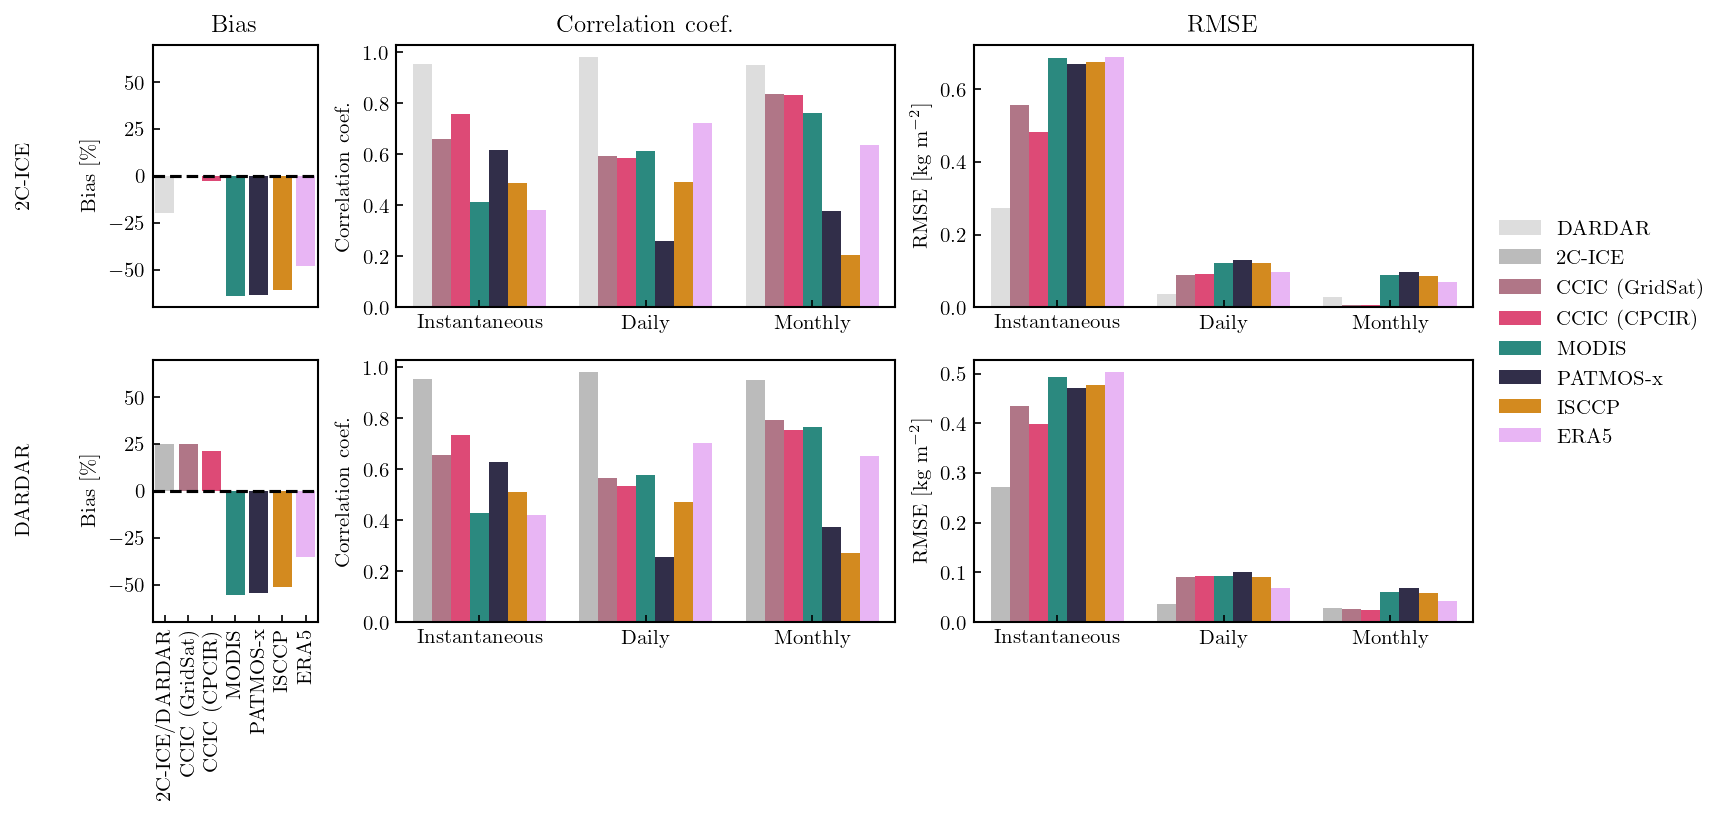

In [49]:
import seaborn as sns
sns.reset_orig()
from matplotlib.gridspec import GridSpec

palette = [c0, "C0", "C1", "C2", "C3", "C4"]


fig = plt.figure(figsize=(14, 5))
gs = GridSpec(2, 5, width_ratios=[0.1, 0.33, 1.0, 1.0, 0.2], wspace=0.3)
order = ["ccic_gridsat", "ccic_cpcir", "modis", "patmosx", "isccp", "era5"]

ref_datasets = ["2C-ICE", "DARDAR"]
handles = None

labels = ["2C-ICE/DARDAR", "CCIC (GridSat)", "CCIC (CPCIR)", "MODIS", "PATMOS-x", "ISCCP", "ERA5"]

for row_ind, ref_dataset in enumerate(ref_datasets):

    ax = fig.add_subplot(gs[row_ind, 0])
    ax.set_axis_off()
    ax.text(0, 0, ref_dataset, weight="bold", ha="center", va="center", rotation=90)
    ax.set_ylim([-2, 2])
    
    row_order = [rd.lower().replace("-", "") for rd in ref_datasets if rd != ref_dataset] + order
    row_palette = ["#dddddd" if ref_dataset == "2C-ICE" else "#bbbbbb"] + palette
    
    ax = fig.add_subplot(gs[row_ind, 1])
    if row_ind == 0:
        ax.set_title("Bias", loc="center")
    sns.barplot(x="Dataset", y=f"Bias ({ref_dataset})", data=all_stats, palette=row_palette, order=row_order, legend=False)
    ax.set_ylabel("Bias [\%]")
    ax.set_xlabel("Scale", fontweight="bold")
    ax.set_ylim(-70, 70)
    ax.axhline(0, ls="--", c="k")
    ax.set_xlabel("")
    if row_ind == 0:
        ax.set_xticks([])
    else:
        ax.set_xticklabels(labels)
        for l in ax.get_xticklabels():
            l.set_rotation(90)
    
    ax = fig.add_subplot(gs[row_ind, 2])
    if row_ind == 0:
        ax.set_title("Correlation coef.", loc="center")
    sns.barplot(x="Scale", hue="Dataset", y=f"Correlation coef ({ref_dataset})", data=all_stats, hue_order=row_order, palette=row_palette)
    ax.legend().remove()
    ax.set_ylabel("Correlation coef.")
    ax.set_xlabel("")
    
    ax = fig.add_subplot(gs[row_ind, 3])
    if row_ind == 0:
        ax.set_title("RMSE", loc="center")
    sns.barplot(x="Scale", hue="Dataset", y=f"RMSE ({ref_dataset})", data=all_stats, hue_order=row_order, palette=row_palette)
    ax.set_ylabel("RMSE [kg m$^{-2}$]")

    if handles is None:
        handles, lbls = ax.get_legend_handles_labels()
    else:
        handles_new, lbls_new = ax.get_legend_handles_labels()
        handles = handles[:1] + handles_new
        lbls = lbls[:1] + lbls_new
    ax.legend().remove()
    ax.set_xlabel("")

ax = fig.add_subplot(gs[:, -1])
labels = ["DARDAR", "2C-ICE", "CCIC (GridSat)", "CCIC (CPCIR)", "MODIS", "PATMOS-x", "ISCCP", "ERA5"]
ax.legend(handles, labels, frameon=False, loc="center")
ax.set_axis_off()
fig.savefig("../../figures/validation_statistics.pdf", bbox_inches="tight")

/tmp/ipykernel_2912336/884966075.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Dataset", y=f"Bias ({ref_dataset})", data=all_stats, palette=row_palette, order=row_order, legend=False)
/tmp/ipykernel_2912336/884966075.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Dataset", y=f"Bias ({ref_dataset})", data=all_stats, palette=row_palette, order=row_order, legend=False)
/tmp/ipykernel_2912336/884966075.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels)


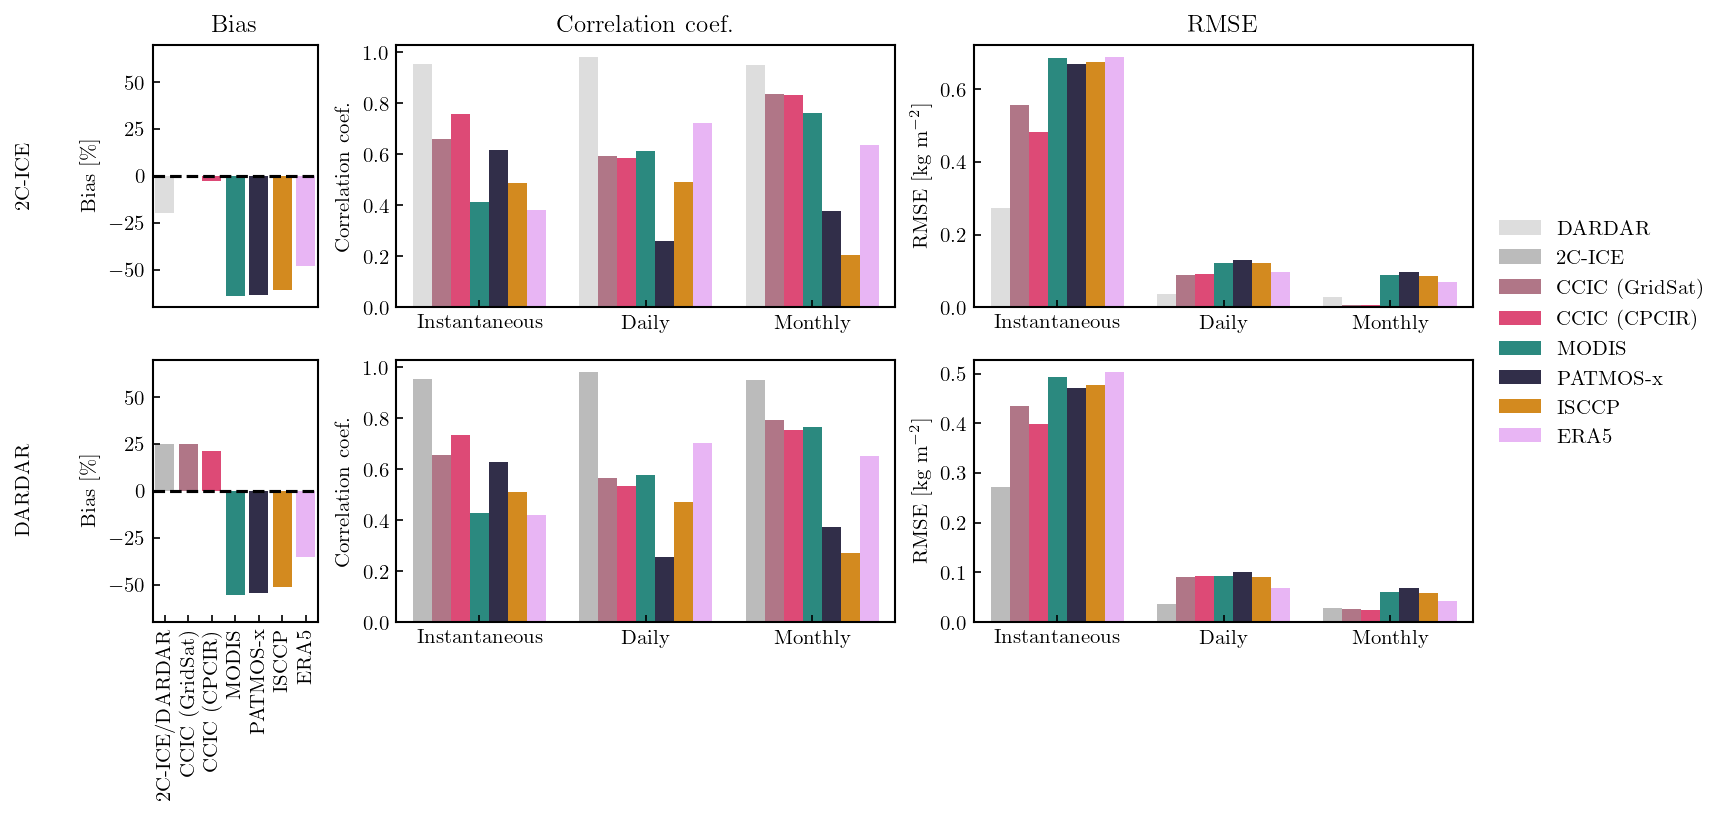

In [50]:
import seaborn as sns
sns.reset_orig()
from matplotlib.gridspec import GridSpec

palette = [c0, "C0", "C1", "C2", "C3", "C4"]


fig = plt.figure(figsize=(14, 5))
gs = GridSpec(2, 5, width_ratios=[0.1, 0.33, 1.0, 1.0, 0.2], wspace=0.3)
order = ["ccic_gridsat", "ccic_cpcir", "modis", "patmosx", "isccp", "era5"]

ref_datasets = ["2C-ICE", "DARDAR"]
handles = None

labels = ["2C-ICE/DARDAR", "CCIC (GridSat)", "CCIC (CPCIR)", "MODIS", "PATMOS-x", "ISCCP", "ERA5"]

for row_ind, ref_dataset in enumerate(ref_datasets):

    ax = fig.add_subplot(gs[row_ind, 0])
    ax.set_axis_off()
    ax.text(0, 0, ref_dataset, weight="bold", ha="center", va="center", rotation=90)
    ax.set_ylim([-2, 2])
    
    row_order = [rd.lower().replace("-", "") for rd in ref_datasets if rd != ref_dataset] + order
    row_palette = ["#dddddd" if ref_dataset == "2C-ICE" else "#bbbbbb"] + palette
    
    ax = fig.add_subplot(gs[row_ind, 1])
    if row_ind == 0:
        ax.set_title("Bias", loc="center")
    sns.barplot(x="Dataset", y=f"Bias ({ref_dataset})", data=all_stats, palette=row_palette, order=row_order, legend=False)
    ax.set_ylabel("Bias [\%]")
    ax.set_xlabel("Scale", fontweight="bold")
    ax.set_ylim(-70, 70)
    ax.axhline(0, ls="--", c="k")
    ax.set_xlabel("")
    if row_ind == 0:
        ax.set_xticks([])
    else:
        ax.set_xticklabels(labels)
        for l in ax.get_xticklabels():
            l.set_rotation(90)
    
    ax = fig.add_subplot(gs[row_ind, 2])
    if row_ind == 0:
        ax.set_title("Correlation coef.", loc="center")
    sns.barplot(x="Scale", hue="Dataset", y=f"Correlation coef ({ref_dataset})", data=all_stats, hue_order=row_order, palette=row_palette)
    ax.legend().remove()
    ax.set_ylabel("Correlation coef.")
    ax.set_xlabel("")
    
    ax = fig.add_subplot(gs[row_ind, 3])
    if row_ind == 0:
        ax.set_title("RMSE", loc="center")
    sns.barplot(x="Scale", hue="Dataset", y=f"RMSE ({ref_dataset})", data=all_stats, hue_order=row_order, palette=row_palette)
    ax.set_ylabel("RMSE [kg m$^{-2}$]")

    if handles is None:
        handles, lbls = ax.get_legend_handles_labels()
    else:
        handles_new, lbls_new = ax.get_legend_handles_labels()
        handles = handles[:1] + handles_new
        lbls = lbls[:1] + lbls_new
    ax.legend().remove()
    ax.set_xlabel("")

ax = fig.add_subplot(gs[:, -1])
labels = ["DARDAR", "2C-ICE", "CCIC (GridSat)", "CCIC (CPCIR)", "MODIS", "PATMOS-x", "ISCCP", "ERA5"]
ax.legend(handles, labels, frameon=False, loc="center")
ax.set_axis_off()
fig.savefig("../../figures/validation_statistics.pdf", bbox_inches="tight")

## Scatter plots

In [100]:
total = daily_stats.sum("time")

KeyError: "No variable named 'dist_ccic_gridsat_old_2cice'. Variables on the dataset include ['tiwp_2cice_sum', 'tiwp_2cice_sqrsum', 'tiwp_2cice_2cice_sum', 'tiwp_2cice_dardar_sum', 'bins_boundaries', ..., 'tiwp_era5_2cice_sum', 'tiwp_era5_dardar_sum', 'dist_era5_2cice', 'dist_era5_dardar', 'counts']"

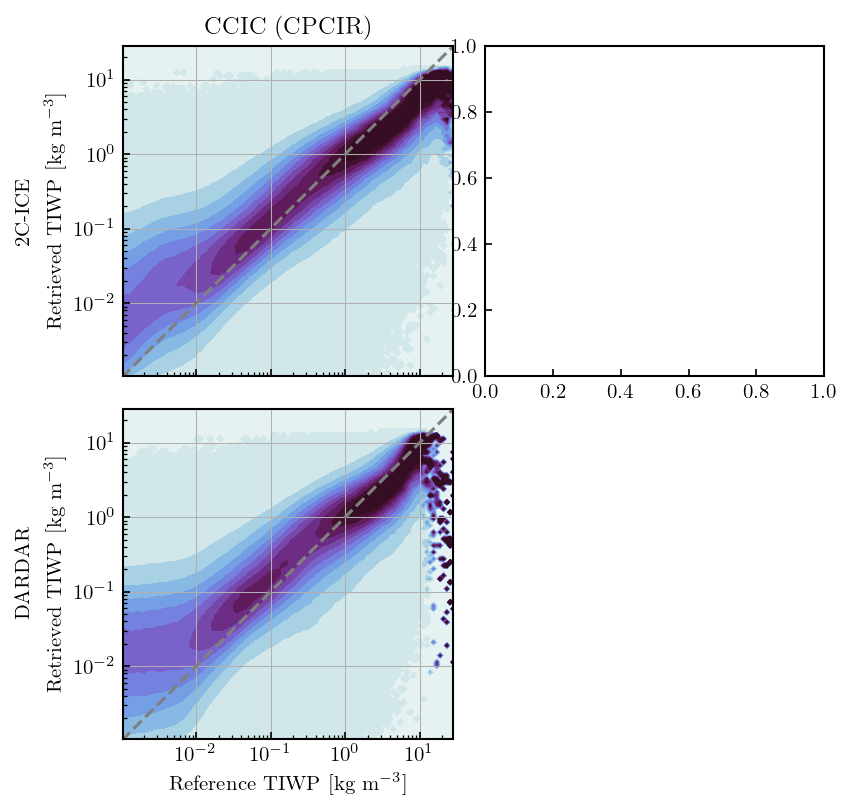

In [101]:
from matplotlib.gridspec import GridSpec
fig = plt.figure(figsize=(20, 6))
gs = GridSpec(2, 8, width_ratios=[0.2, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.1], hspace=0.1, wspace=0.1)

prods = {
    "CCIC (CPCIR)": "ccic_cpcir",
    "CCIC (GridSat)": "ccic_gridsat_old",
    "Modis": "modis",
    "PATMOS-x": "patmosx", 
    "ISCCP": "isccp", 
    "ERA5": "era5", 
}

bins = np.logspace(-3, np.log10(30), 101)
x = 0.5 * (bins[1:] + bins[:-1])
levels = np.linspace(0, 0.05, 11)


for ind, (name, prod) in enumerate(prods.items()):

    if ind == 0:
        ax = fig.add_subplot(gs[0, 0])
        ax.set_axis_off()
        ax.text(0, 0, "2C-ICE", va="center", ha="center", rotation=90, weight="bold")
        ax.set_ylim(-2, 2)
        
        ax = fig.add_subplot(gs[1, 0])
        ax.set_axis_off()
        ax.text(0, 0, "DARDAR", va="center", ha="center", rotation=90)
        ax.set_ylim(-2, 2)
    
    ax = fig.add_subplot(gs[0, ind + 1])
    dist = total[f"dist_{prod}_2cice"].data.copy()
    dist /= dist.sum(1, keepdims=True)
    ax.pcolormesh(bins, bins, dist.T, vmin=0, vmax=0.05)
    ax.contourf(x, x, dist.T, levels=levels, extend="both", vmin=0, vmax=0.05)
    ax.plot(bins, bins, c="grey", ls="--")
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_aspect(1.0)
    ax.grid()
    ax.set_xlim(x[0], x[-1])
    ax.set_ylim(x[0], x[-1])

    if ind == 0:
        ax.set_ylabel("Retrieved TIWP [kg m$^{-3}$]")
    else:
        ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_title(name, loc="center")
        
    
    ax = fig.add_subplot(gs[1, ind + 1])
    dist = total[f"dist_{prod}_dardar"].data.copy()
    dist /= dist.sum(1, keepdims=True)
    mappable = ax.contourf(x, x, dist.T, vmin=0, vmax=0.05, levels=levels, extend="both")
    ax.plot(bins, bins, c="grey", ls="--")
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_aspect(1.0)
    ax.grid()
    ax.set_xlim(x[0], x[-1])
    ax.set_ylim(x[0], x[-1])

    if ind == 0:
        ax.set_ylabel("Retrieved TIWP [kg m$^{-3}$]")
    else:
        ax.set_yticklabels([])
        
    ax.set_xlabel("Reference TIWP [kg m$^{-3}$]")

cax = fig.add_subplot(gs[:, -1])
plt.colorbar(mappable, cax=cax, label="Normalized frequency")
fig.savefig("../../figures/scatter_plots.pdf", bbox_inches="tight")

In [108]:
from pansat.environment import get_index
from pansat.products.satellite.ccic import ccic_gridsat


In [110]:
ind = get_index(ccic_gridsat)
ind

<Index of 'satellite.ccic.ccic_gridsat' containing 0 entries>